## Imports

In [1]:
import os
import subprocess

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)


from collections import Counter
#import regex as regex

pandas 0.24.2
numpy 1.16.2
matplotlib 3.0.3
scipy 1.2.1


## Basic Function and Data Imports

In [2]:
def reverse_complement(dna):
    """ function that reverse complements DNA
    dna: input dna sequence
    """
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join([complement[base] for base in dna[::-1]])

def get_dict_of_seq(fasta_file):
    """ function that converts a fasta file to a dictionnary of sequences
    fasta_file: the input fasta file
    """
    
    file_fasta_dict = {}
    # output dict of imported seqs
    
    with open(fasta_file, 'r') as fasta:    
        for line in fasta:
            # loops through the file

            if line.startswith('>') == True:
                seq_info = line.strip('>').strip('\n').split('\t')[0]
                file_fasta_dict[seq_info] = ''
                # checks if seq header

            else:
                file_fasta_dict[seq_info] += line.strip('\n')
                # If not, append nt to current seq
                
    return file_fasta_dict


universal_seqs_fasta = "./uni_amplicon_sequences/universal_amplicon.fa"
universal_seqs = get_dict_of_seq(universal_seqs_fasta)
print(universal_seqs)

indexes_fasta = "./uni_amplicon_sequences/indexes.fa"
indexes = get_dict_of_seq(indexes_fasta)
print(indexes)

degen_seq = 'AAAAA'

{'Index_five_prime': 'AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTNNNNN', 'Index_three_prime': 'NNNNNAGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTG', 'plate_fivep_sticky': 'TAACTTACGGAGTCGCTCTACG', 'RC_fivep_sticky': 'CCATACGAGCACATTACGGG', 'plate_threep_sticky': 'CAGGACCTAAAGAATCCCATCC', 'RC_threep_sticky': 'CCTCAGTCGCTCAGTCAAG', 'five_prime_adapter': 'AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCT', 'three_prime_adapter': 'AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTG'}
{'1': 'CAAGTGTTC', '2': 'AGGACATTC', '3': 'CACTAATGG', '4': 'AGCCTGATG', '5': 'TTACGCTAA', '6': 'ACTCTCCGT', '7': 'GTCGATGCA', '8': 'ACGGGAATT', '9': 'CGCGCCCAG', '10': 'ACTAGTTTG', '11': 'AGTATTACA', '12': 'AGGTTGGGT', '13': 'GTGAACCGA', '14': 'GCACAAAAC', '15': 'CTGTCTTCG', '16': 'GACGCGACT', '17': 'CAGCCCATA', '18': 'AGATATCTG'}


## Import sample information from standardized csv file

In [3]:
experiment_name = 'BE_timecourse'

path_to_R1_file = './MiSeq_24sept2019/Undetermined_S0_L001_R1_001.fastq.gz'

path_to_R2_file = './MiSeq_24sept2019/Undetermined_S0_L001_R2_001.fastq.gz'


sample_datasheet = './specific_amplicon_sequences/sample_datasheet.csv'

sample_dataframe = pd.read_csv(sample_datasheet, index_col='Sample_ID')

sample_dataframe.head(10)

,Locus,Type,Well,Timepoint,Replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index
Sample_ID,,,,,,,,,
1,ADE1,locus,A1,T0,1,2,1,1,2
2,ADE1,locus,B1,T0,2,2,2,1,2
3,ADE1,locus,C1,T6,1,2,3,1,2
4,ADE1,locus,D1,T6,2,2,4,1,2
5,ADE1,locus,E1,T12,1,2,5,1,2
6,ADE1,locus,F1,T12,2,2,6,1,2
7,ADE1,locus,G1,Plating,1,2,7,1,2
8,ADE1,locus,H1,Plating,2,2,8,1,2
9,ADE1,locus,I1,can_recov,1,2,9,1,2


In [4]:
print(len(sample_dataframe))

240


Make sure this matches the expected number of samples

## Check sequencing run stats using Fastqc

Open the HTML files created in the directory where the sequencing files were located and inspect the fastqc stats

## Remove reads below the expected length

We use the read pairs which survived for downstream analysis, filenames: minlen299_1P.fastq  minlen299_2P.fastq

## Generate the Bowtie indexes for aligning the forward and reverse plate indexes

In [90]:
plate_index_pair_list = []

for sample in sample_dataframe.index:
    
    PE1_index = sample_dataframe.loc[sample]['PE1_index']
    PE2_index = sample_dataframe.loc[sample]['PE2_index']
    
    index_pair = tuple((PE1_index,PE2_index))
    
    if index_pair not in plate_index_pair_list:
        plate_index_pair_list.append(index_pair)
        
print(plate_index_pair_list)
# this shows the different combinations of plate barcodes used in the experiment

[(2, 2), (3, 3)]


In [91]:
plate_pcr_amplicon_for = './intermediate_data/amplicon_seqs/plate_pcr_for.fa'
plate_pcr_amplicon_rev = './intermediate_data/amplicon_seqs/plate_pcr_rev.fa'

for_plate_indexes = list(sample_dataframe.PE1_index.unique())

rev_plate_indexes = list(sample_dataframe.PE2_index.unique())

print(for_plate_indexes)
print(rev_plate_indexes)


with open(plate_pcr_amplicon_for, 'w') as fasta_out:
    
    for index in for_plate_indexes:

        index_seq = indexes[str(index)]
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        
        amplicon_frag = degen_seq+index_seq+universal_seqs['plate_fivep_sticky']+'\n'
        fasta_out.write(amplicon_frag)
        
        
for_plate_index = './intermediate_data/bowtie_indexes/'+experiment_name+'_for_plate'
for_plate_bowtie_index_call = 'bowtie-build -f -r -o 4 '+plate_pcr_amplicon_for+' '+for_plate_index
for_plate_indexing_log = subprocess.check_output(for_plate_bowtie_index_call, shell=True)
        
        
with open(plate_pcr_amplicon_rev, 'w') as fasta_out:
    
    for index in rev_plate_indexes:

        index_seq = indexes[str(index)]
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        
        amplicon_frag = degen_seq + index_seq+ reverse_complement(universal_seqs['plate_threep_sticky'])+'\n'
        fasta_out.write(amplicon_frag)    
    
rev_plate_index = './intermediate_data/bowtie_indexes/'+experiment_name+'_rev_plate'
rev_plate_bowtie_index_call = 'bowtie-build -f -r -o 4 '+plate_pcr_amplicon_rev+' '+rev_plate_index
rev_plate_indexing_log = subprocess.check_output(rev_plate_bowtie_index_call, shell=True)
    
    
    

[2, 3]
[2, 3]


## Alignments of the plate barcodes

In [92]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 280 --trim5 5 --norc --chunkmbs 256 '
test_align_call += for_plate_index+' '
test_align_call += './temp/minlen299_1P.fastq '
test_align_call += './temp/plate_for_align.txt'

print (test_align_call)

subprocess.check_output(test_align_call, shell = True)

bowtie -t -v 3 -p 6 -k 1 --trim3 280 --trim5 5 --norc --chunkmbs 256 ./intermediate_data/bowtie_indexes/BE_timecourse_for_plate ./temp/minlen299_1P.fastq ./temp/plate_for_align.txt


b''

In [93]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 280 --trim5 5 --norc --chunkmbs 256 '
test_align_call += rev_plate_index+' '
test_align_call += './temp/minlen299_2P.fastq '
test_align_call += './temp/plate_rev_align.txt'
print (test_align_call)
subprocess.check_output(test_align_call, shell = True)

bowtie -t -v 3 -p 6 -k 1 --trim3 280 --trim5 5 --norc --chunkmbs 256 ./intermediate_data/bowtie_indexes/BE_timecourse_rev_plate ./temp/minlen299_2P.fastq ./temp/plate_rev_align.txt


b''

In [94]:
plate_align_for_output = './temp/plate_for_align.txt'
plate_align_rev_output = './temp/plate_rev_align.txt'


plate_index_found_for = {}
plate_index_found_rev = {}
# empty containers that will hold    read_name: index    data pairs for the forward and reverse reads that
# had valid alignments


with open(plate_align_for_output, 'r') as for_index_positives:
    for line in for_index_positives:
        # opens P1 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info, not the illumina annotations in the read 
        # name. See http://support.illumina.com/content/dam/illumina-support/help/BaseSpaceHelp_v2/Content/Vault/
        #           Informatics/Sequencing_Analysis/BS/swSEQ_mBS_FASTQFiles.htm
        # For info on illumina read name convention
        plate_index_found_for[read_name] = line[2]
        # add read P1 index to dict

#log_entry['for_index_pos'] = len(index_found_for.keys())
# log entry: number of reads with valid P1 index alignments

with open(plate_align_rev_output, 'r') as rev_index_positives:
    for line in rev_index_positives:
        # opens P2 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info
        plate_index_found_rev[read_name] = line[2]
        # add read P2 index to dict

#log_entry['rev_index_pos'] = len(index_found_rev.keys())
# log entry: number of reads with valid P2 index alignments


plate_both = list(set(plate_index_found_for.keys()) & set(plate_index_found_rev.keys()))
#log_entry['both_index'] = len(both_indexes)
# Use the set data format to quickly id reads with valid alignments for both P1 and P2 indexes, and stores the
# taht number for the read pack in the log
print(len(plate_both))



612422


## Get reads per plate

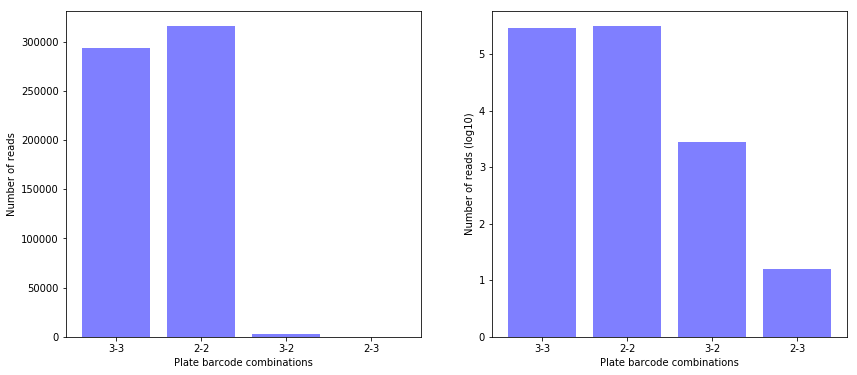

In [95]:
def plot_reads_per_plate(shared_index_list, index_for_dict, index_rev_dict):
    
    plate_read_counter = Counter()
    
    for read in shared_index_list:
        
        for_index = index_for_dict[read]
        rev_index = index_rev_dict[read]
        
        plate = for_index+'-'+rev_index
        
        plate_read_counter[plate] +=1
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.bar(range(len(plate_read_counter)), list(plate_read_counter.values()), align='center', color = 'blue', alpha=0.5)
    plt.xticks(range(len(plate_read_counter)), list(plate_read_counter.keys()))
    plt.xlabel('Plate barcode combinations')
    plt.ylabel('Number of reads')
    
    plt.subplot(122)
    plt.bar(range(len(plate_read_counter)), [np.log10(x) for x in plate_read_counter.values()], align='center', color = 'blue', alpha=0.5)
    plt.xticks(range(len(plate_read_counter)), list(plate_read_counter.keys()))
    plt.xlabel('Plate barcode combinations')
    plt.ylabel('Number of reads (log10)')
    
plot_reads_per_plate(plate_both, plate_index_found_for, plate_index_found_rev)

## Customized figure

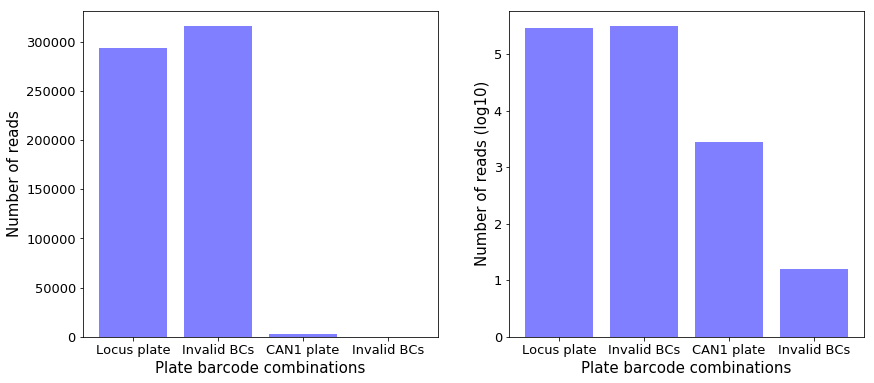

In [96]:
def plot_reads_per_plate(shared_index_list, index_for_dict, index_rev_dict):
    
    plate_read_counter = Counter()
    
    for read in shared_index_list:
        
        for_index = index_for_dict[read]
        rev_index = index_rev_dict[read]
        
        plate = for_index+'-'+rev_index
        
        plate_read_counter[plate] +=1
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.bar(range(len(plate_read_counter)), list(plate_read_counter.values()), align='center', color = 'blue', alpha=0.5)
    plt.xticks(range(len(plate_read_counter)), ['Locus plate', 'Invalid BCs', 'CAN1 plate', 'Invalid BCs'], fontsize=13)
    plt.xlabel('Plate barcode combinations', fontsize = 15)
    plt.ylabel('Number of reads', fontsize =15)
    plt.yticks(fontsize=13)

    
    plt.subplot(122)
    plt.bar(range(len(plate_read_counter)), [np.log10(x) for x in plate_read_counter.values()], align='center', color = 'blue', alpha=0.5)
    plt.xticks(range(len(plate_read_counter)), ['Locus plate', 'Invalid BCs', 'CAN1 plate', 'Invalid BCs'], fontsize=13)
    plt.xlabel('Plate barcode combinations', fontsize = 15)
    plt.ylabel('Number of reads (log10)', fontsize =15)
    plt.yticks(fontsize=13)
    
plot_reads_per_plate(plate_both, plate_index_found_for, plate_index_found_rev)

## Generate indexes for Row-Column alignments

In [97]:
RC_index_pair_list = []

for sample in sample_dataframe.index:
    
    RC_for_index = sample_dataframe.loc[sample]['RC_for_index']
    RC_rev_index = sample_dataframe.loc[sample]['RC_rev_index']
    
    index_pair = tuple((RC_for_index,RC_rev_index))
    
    if index_pair not in RC_index_pair_list:
        RC_index_pair_list.append(index_pair)
print(len(RC_index_pair_list))        
print(RC_index_pair_list)
# this shows the different combinations of plate barcodes used in the experiment

120
[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (7, 6), (8, 6), (9, 6), (10, 6), (1, 7), (2, 7), (3, 7), (4, 7), (5, 7), (6, 7), (7, 7), (8, 7), (9, 7), (10, 7), (1, 8), (2, 8), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (10, 8), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9), (10, 9), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10), (1, 12), (2, 12), (3, 12), (4, 12), (5, 12), (6, 12), (7, 12), (8, 12), (9, 12), (10, 12), (1, 13), (2, 13), (3, 13), (4, 13), (5, 13), (6, 13), (7, 13), (8, 13), (9, 13), (10

In [98]:
RC_pcr_amplicon_for = './intermediate_data/amplicon_seqs/RC_pcr_for.fa'
RC_pcr_amplicon_rev = './intermediate_data/amplicon_seqs/RC_pcr_rev.fa'

RC_for_indexes = list(sample_dataframe.RC_for_index.unique())

RC_rev_indexes = list(sample_dataframe.RC_rev_index.unique())

print(RC_for_indexes)
print(RC_rev_indexes)


with open(RC_pcr_amplicon_for, 'w') as fasta_out:
    
    for index in RC_for_indexes:

        index_seq = indexes[str(index)]
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        
        amplicon_frag = universal_seqs['plate_fivep_sticky']+index_seq+universal_seqs['RC_fivep_sticky']+'\n'
        fasta_out.write(amplicon_frag)
        
        
for_RC_index = './intermediate_data/bowtie_indexes/'+experiment_name+'_for_RC'
for_RC_bowtie_index_call = 'bowtie-build -f -r -o 4 '+RC_pcr_amplicon_for+' '+for_RC_index
for_RC_indexing_log = subprocess.check_output(for_RC_bowtie_index_call, shell=True)
        
        
with open(RC_pcr_amplicon_rev, 'w') as fasta_out:
    
    for index in RC_rev_indexes:

        index_seq = indexes[str(index)]
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        
        amplicon_frag = reverse_complement(universal_seqs['plate_threep_sticky']) + index_seq
        amplicon_frag += reverse_complement(universal_seqs['RC_threep_sticky'])+'\n'
        fasta_out.write(amplicon_frag)    
    
rev_RC_index = './intermediate_data/bowtie_indexes/'+experiment_name+'_rev_RC'
rev_RC_bowtie_index_call = 'bowtie-build -f -r -o 4 '+RC_pcr_amplicon_rev+' '+rev_RC_index
rev_RC_indexing_log = subprocess.check_output(rev_RC_bowtie_index_call, shell=True)
    

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]


In [99]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 245 --trim5 28 --norc --chunkmbs 256 '
test_align_call += for_RC_index+' '
test_align_call += './temp/minlen299_1P.fastq '
test_align_call += './temp/RC_for_align.txt'

subprocess.check_output(test_align_call, shell = True)

b''

In [100]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 247 --trim5 26 --norc --chunkmbs 256 '
test_align_call += rev_RC_index+' '
test_align_call += './temp/minlen299_2P.fastq '
test_align_call += './temp/RC_rev_align.txt'

subprocess.check_output(test_align_call, shell = True)

b''

In [101]:
RC_align_for_output = './temp/RC_for_align.txt'
RC_align_rev_output = './temp/RC_rev_align.txt'


index_found_for_RC = {}
index_found_rev_RC = {}
# empty containers that will hold    read_name: index    data pairs for the forward and reverse reads that
# had valid alignments


with open(RC_align_for_output, 'r') as for_index_positives:
    for line in for_index_positives:
        # opens P1 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info, not the illumina annotations in the read 
        # name. See http://support.illumina.com/content/dam/illumina-support/help/BaseSpaceHelp_v2/Content/Vault/
        #           Informatics/Sequencing_Analysis/BS/swSEQ_mBS_FASTQFiles.htm
        # For info on illumina read name convention
        index_found_for_RC[read_name] = line[2]
        # add read P1 index to dict

#log_entry['for_index_pos'] = len(index_found_for.keys())
# log entry: number of reads with valid P1 index alignments

with open(RC_align_rev_output, 'r') as rev_index_positives:
    for line in rev_index_positives:
        # opens P2 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info
        index_found_rev_RC[read_name] = line[2]
        # add read P2 index to dict

#log_entry['rev_index_pos'] = len(index_found_rev.keys())
# log entry: number of reads with valid P2 index alignments


both_indexes_RC = list(set(index_found_for_RC.keys()) & set(index_found_rev_RC.keys()))
#log_entry['both_index'] = len(both_indexes)
# Use the set data format to quickly id reads with valid alignments for both P1 and P2 indexes, and stores the
# taht number for the read pack in the log
print(len(both_indexes_RC))



597001


In [102]:
valid_plates = [tuple((2,2)), tuple((3,3))]


def plot_reads_in_plate(plate_both, RC_both, plate_index_found_for, plate_index_found_rev, index_found_for_RC, index_found_rev_RC, plate,
                       silent=False):
    
    plate_rows = sorted(set(index_found_for_RC.values()))
    plate_columns = sorted(set(index_found_rev_RC.values()))
    
    read_plate_RC_dict = {}
    grid_dict = {}
    
    for row in plate_rows:
        
        grid_dict[int(row)] = {}
        
        #print(row)
        
        for column in plate_columns:
            
            #print(type(column))
            
            grid_dict[int(row)][int(column)] = 0
            
    if silent == False:
        
        print(grid_dict)
    
    plate_and_rc_both = list((set(plate_both)&set(both_indexes_RC)))
    
    for read in plate_and_rc_both:
        
        for_index_plate = int(plate_index_found_for[read])
        rev_index_plate = int(plate_index_found_rev[read])
        
        #print(for_index_plate, rev_index_plate)
        
        #print(plate)
        #print(tuple((for_index_plate,rev_index_plate)))
        
        if tuple((int(for_index_plate), int(rev_index_plate))) == plate:
            
            #print('ok')
            
            for_index_RC = int(index_found_for_RC[read])
            rev_index_RC = int(index_found_rev_RC[read])
            
            #print(for_index_RC, rev_index_RC)
            #print(grid_dict[for_index_RC][rev_index_RC])
            
            grid_dict[for_index_RC][rev_index_RC] += 1
            
            read_plate_RC_dict[read] = [int(for_index_plate), int(rev_index_plate), for_index_RC, rev_index_RC]
            
            
            
    plate_df = pd.DataFrame.from_dict(grid_dict, orient='index')
    return plate_df, read_plate_RC_dict
            
            
locus = plot_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
                                index_found_rev_RC, valid_plates[0], silent = False)

{1: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 10: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 2: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 3: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 4: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 5: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 6: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 7: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 8: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 9: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}}


In [103]:
import seaborn as sns
from matplotlib.colors import LogNorm
locus[0].head(10)

,1,10,12,13,2,3,4,5,6,7,8,9
1,9669,1901,6024,16898,2703,9423,4806,4821,6898,7911,1286,4178
2,260,357,2228,277,960,35,1211,698,2584,3276,335,4124
3,146,182,1334,306,503,1177,1525,624,1582,2686,257,3455
4,958,424,1308,1035,1372,856,2178,1511,3187,3427,334,3498
5,711,716,2322,496,1331,358,973,489,2634,3044,313,627
6,2147,745,2475,242,2357,951,1767,816,355,3891,750,1435
7,6154,1069,4736,4210,1311,2221,3734,3076,1919,1472,621,4192
8,11797,2219,5581,6606,137,8836,4808,905,47,2914,659,5055
9,3687,1655,3275,1302,2307,3859,4532,4275,5635,0,866,5989
10,743,1545,3093,3371,1405,1843,3282,2753,2224,1,1242,1767


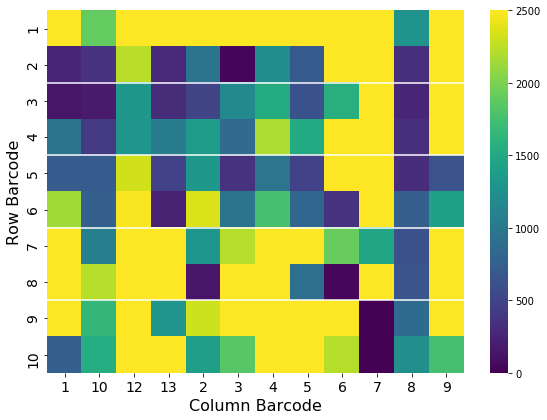

In [104]:
plt.figure(figsize=(14/1.5, 10/1.5))


sns.heatmap(locus[0], vmax=2500, cmap='viridis',)
plt.xlabel('Column Barcode', fontsize = 16)
plt.ylabel('Row Barcode', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.axhline(2, color='white')
plt.axhline(4, color='white')
plt.axhline(6, color='white')
plt.axhline(8, color='white')

In [105]:
locus[0].sum().sum()

303603

In [106]:
CAN1 = plot_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
                                index_found_rev_RC, valid_plates[1])

{1: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 10: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 2: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 3: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 4: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 5: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 6: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 7: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 8: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}, 9: {1: 0, 10: 0, 12: 0, 13: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}}


In [107]:
CAN1[0].head(10)

,1,10,12,13,2,3,4,5,6,7,8,9
1,2393,3153,3417,126,1223,3330,2877,2981,3158,2732,3139,1841
2,1153,2026,2466,2776,1511,1784,1956,2040,2452,2426,1905,1940
3,564,5443,1579,2106,1614,1148,1201,1603,1650,1480,1167,1394
4,621,1390,5158,1862,919,1030,1387,1812,1849,1409,1356,3736
5,1095,2236,2131,1610,1304,1655,2269,2578,2813,2499,2606,1745
6,859,1025,1391,483,817,1260,1511,1847,1678,1807,1887,1047
7,2813,4249,3796,3548,1842,2634,3498,13561,4208,4027,4689,3302
8,3768,1506,3833,2529,3716,4202,4295,4914,4185,4084,4458,3945
9,740,1589,1458,1457,958,982,1560,1538,1100,70,96,1388
10,3122,2515,2704,2524,3247,2823,3111,2963,3096,120,3140,2710


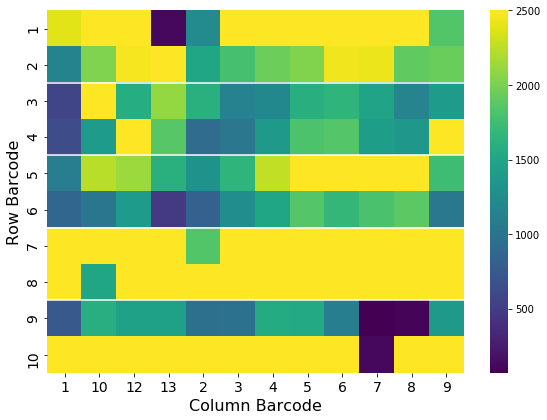

In [108]:
plt.figure(figsize=(14/1.5, 10/1.5))


sns.heatmap(CAN1[0], vmax=2500, cmap='viridis',)
plt.xlabel('Column Barcode', fontsize = 16)
plt.ylabel('Row Barcode', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.axhline(2, color='white')
plt.axhline(4, color='white')
plt.axhline(6, color='white')
plt.axhline(8, color='white')

In [109]:
CAN1[0].sum().sum()

281049

In [110]:
all_plate_index_dicts = []

for plate in valid_plates:
    
    mapping = plot_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
                                index_found_rev_RC, plate, silent=True)[1]
    
    all_plate_index_dicts.append(mapping)


In [111]:
plate_RC_combi_to_dict = {}

out_fastq_path_dict_for_df = {}

out_fastq_path_dict_demult = {}

dir_path = './intermediate_data/demultiplexed_reads/'


for sample in sample_dataframe.index:
    
    plate_for = sample_dataframe.loc[sample]['PE1_index']
    RC_for = sample_dataframe.loc[sample]['RC_for_index']
    RC_rev = sample_dataframe.loc[sample]['RC_rev_index']
    plate_rev = sample_dataframe.loc[sample]['PE2_index']
    
    plate_RC_combi_to_dict[sample] = [plate_for, plate_rev, RC_for, RC_rev]
    
    out_path = dir_path+str(sample)+'_indexes_'+str(plate_for)+'_'+str(plate_rev)+'_'+str(RC_for)+'_'+str(RC_rev)
    
    out_path_1 = dir_path+str(sample)+'_indexes_'+str(plate_for)+'_'+str(plate_rev)+'_'+str(RC_for)+'_'+str(RC_rev)+'_for'+'.fastq'
    out_path_2 = dir_path+str(sample)+'_indexes_'+str(plate_for)+'_'+str(plate_rev)+'_'+str(RC_for)+'_'+str(RC_rev)+'_rev'+'.fastq'
    
    out_fastq_path_dict_for_df[sample] = out_path
    
    out_fastq_path_dict_demult[tuple([plate_for, plate_rev, RC_for, RC_rev])] = out_path
    
    create_file_for = 'touch '+ out_path_1
    create_file_rev = 'touch '+ out_path_2
    
    subprocess.check_output(create_file_for, shell=True)
    subprocess.check_output(create_file_rev, shell=True)
    


for plate_dict in all_plate_index_dicts:
    
    print(len(plate_dict.keys()))

    for read in list(plate_dict.keys()):

        index_combi = plate_dict[read]

        if index_combi not in plate_RC_combi_to_dict.values():

            plate_dict.pop(read, None)
        
    print(len(plate_dict.keys()))


303603
303603
281049
281049


In [112]:
print (list(all_plate_index_dicts[0].keys())[0:10])

['M01893:366:000000000-CLKPV:1:2108:16059:18401', 'M01893:366:000000000-CLKPV:1:2112:8531:7965', 'M01893:366:000000000-CLKPV:1:2102:17641:24800', 'M01893:366:000000000-CLKPV:1:2113:10169:3157', 'M01893:366:000000000-CLKPV:1:1107:6430:10394', 'M01893:366:000000000-CLKPV:1:2110:13581:12310', 'M01893:366:000000000-CLKPV:1:1114:15402:17498', 'M01893:366:000000000-CLKPV:1:1104:14945:10539', 'M01893:366:000000000-CLKPV:1:2112:19923:7630', 'M01893:366:000000000-CLKPV:1:1114:6934:24056']


In [113]:
def split_reads_from_fastq(file, file_type, plate_mapping_list):
    
    to_write = 'none'
    read_name = 'none'
    
    
    with open(file, 'r') as source_fastq:
        
        for line in source_fastq:
            
            #print(read_name)
            #print(line)

            if line.startswith('@M') == True:
                
                if to_write == 'none':
                    
                    read_name = line.split(' ')[0].strip('@')
                    to_write = line

                else:
                    
                    for plate_read_dict in plate_mapping_list:
                        
                                                
                        if read_name in plate_read_dict.keys():

                            #print ('ok')

                            indexes = tuple(plate_read_dict[read_name])
                            
                            if file_type == 'forward':
                                
                                file_path = out_fastq_path_dict_demult[indexes]+'_for.fastq'
                                
                            elif file_type == 'reverse':
                                
                                file_path = out_fastq_path_dict_demult[indexes]+'_rev.fastq'

                            
                            
                            with open(file_path, 'a') as dest:
                                
                                   dest.write(to_write)

                            break





                    read_name = line.split(' ')[0].strip('@')

                    to_write = line
                

            else:

                to_write += line
                
split_reads_from_fastq('./temp/minlen299_1P.fastq', 'forward', all_plate_index_dicts)
split_reads_from_fastq('./temp/minlen299_2P.fastq', 'reverse' ,all_plate_index_dicts)

In [ ]:
#split_reads_from_fastq('./temp/minlen299_2P.fastq', 'reverse' ,all_plate_index_dicts)

In [115]:
sample_dataframe['filepath'] = sample_dataframe.index.map(out_fastq_path_dict_for_df)


sample_dataframe.to_csv('./intermediate_data/sample_datasheet_demultiplexed.csv', sep=',')

In [116]:
sample_dataframe.head(10)


,Locus,Type,Well,Timepoint,Replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index,filepath
Sample_ID,,,,,,,,,,
1,ADE1,locus,A1,T0,1,2,1,1,2,./intermediate_data/demultiplexed_reads/1_inde...
2,ADE1,locus,B1,T0,2,2,2,1,2,./intermediate_data/demultiplexed_reads/2_inde...
3,ADE1,locus,C1,T6,1,2,3,1,2,./intermediate_data/demultiplexed_reads/3_inde...
4,ADE1,locus,D1,T6,2,2,4,1,2,./intermediate_data/demultiplexed_reads/4_inde...
5,ADE1,locus,E1,T12,1,2,5,1,2,./intermediate_data/demultiplexed_reads/5_inde...
6,ADE1,locus,F1,T12,2,2,6,1,2,./intermediate_data/demultiplexed_reads/6_inde...
7,ADE1,locus,G1,Plating,1,2,7,1,2,./intermediate_data/demultiplexed_reads/7_inde...
8,ADE1,locus,H1,Plating,2,2,8,1,2,./intermediate_data/demultiplexed_reads/8_inde...
9,ADE1,locus,I1,can_recov,1,2,9,1,2,./intermediate_data/demultiplexed_reads/9_inde...


In [3]:
sample_dataframe = pd.read_csv('./intermediate_data/sample_datasheet_demultiplexed.csv', sep=',', index_col = 'Sample_ID')

sample_dataframe.loc[126]

Locus                                                        ADE1
Type                                                         CAN1
Well                                                           F1
Timepoint                                                     T12
Replicate                                                       2
PE1_index                                                       3
RC_for_index                                                    6
RC_rev_index                                                    1
PE2_index                                                       3
filepath        ./intermediate_data/demultiplexed_reads/126_in...
Name: 126, dtype: object

In [6]:
before_merge_depth_dict = {}



def merge_reads(Sample_ID):
    
    filepath = sample_dataframe.loc[Sample_ID]['filepath']
    
    filepath_for = filepath+'_for.fastq'
    filepath_rev = filepath+'_rev.fastq'
    
    sample_read_count = 0
    
    with open(filepath_for, 'r') as source:
        
        for line in source:
            
            if line.startswith('@M'):
                
                sample_read_count += 1
                
    before_merge_depth_dict[Sample_ID] = sample_read_count
                
    if sample_read_count >= 1:
        
                
        filepath_out = './intermediate_data/merged_reads/'+str(Sample_ID)+'.fasta'


        panda_seq_call = 'pandaseq -f '+filepath_for+' -r '+filepath_rev+ ' -L 400 -O 600 -k 4 -B -T 6 -w '+ filepath_out

        subprocess.check_output(panda_seq_call, shell=True)
        
    return sample_read_count
    
    
merge_reads(11)

2703

## Merge for all samples with at least one read count

In [7]:
for sample_ID in list(sample_dataframe.index):
    
    merge_reads(sample_ID)

In [8]:
sample_dataframe['demult_read_count'] = pd.Series(before_merge_depth_dict)
# add read count info to the dataframe

In [9]:
after_merge_depth_dict = {}

def count_merged(Sample_ID):
    
    filepath = './intermediate_data/merged_reads/'
    
    filepath_merged = str(Sample_ID)+'.fasta'
    
    filepath+=filepath_merged
    
    after_merge_depth = 0
    
    if sample_dataframe.loc[Sample_ID]['demult_read_count'] > 0:
    
        with open(filepath, 'r') as source:

            for line in source:

                if line.startswith('>'):

                    after_merge_depth += 1

    after_merge_depth_dict[Sample_ID] = after_merge_depth
    
    return after_merge_depth
    
    
count_merged(11)    

2336

In [10]:
for sample_ID in list(sample_dataframe.index):
    
    count_merged(sample_ID)
    
sample_dataframe['merged_read_count'] = pd.Series(after_merge_depth_dict)
# add read count info to the dataframe

sample_dataframe.head(10)

,Locus,Type,Well,Timepoint,Replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index,filepath,demult_read_count,merged_read_count
Sample_ID,,,,,,,,,,,,
1,ADE1,locus,A1,T0,1,2,1,1,2,./intermediate_data/demultiplexed_reads/1_inde...,9669,7763
2,ADE1,locus,B1,T0,2,2,2,1,2,./intermediate_data/demultiplexed_reads/2_inde...,260,200
3,ADE1,locus,C1,T6,1,2,3,1,2,./intermediate_data/demultiplexed_reads/3_inde...,146,109
4,ADE1,locus,D1,T6,2,2,4,1,2,./intermediate_data/demultiplexed_reads/4_inde...,958,758
5,ADE1,locus,E1,T12,1,2,5,1,2,./intermediate_data/demultiplexed_reads/5_inde...,711,571
6,ADE1,locus,F1,T12,2,2,6,1,2,./intermediate_data/demultiplexed_reads/6_inde...,2147,1755
7,ADE1,locus,G1,Plating,1,2,7,1,2,./intermediate_data/demultiplexed_reads/7_inde...,6154,4971
8,ADE1,locus,H1,Plating,2,2,8,1,2,./intermediate_data/demultiplexed_reads/8_inde...,11797,9632
9,ADE1,locus,I1,can_recov,1,2,9,1,2,./intermediate_data/demultiplexed_reads/9_inde...,3687,3020


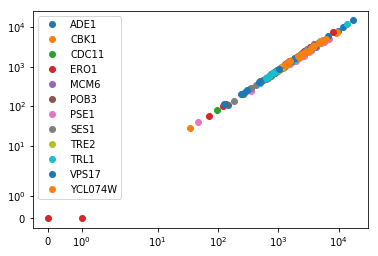

SpearmanrResult(correlation=0.9969924812030074, pvalue=1.891102426799577e-21)


In [11]:
groups = sample_dataframe.groupby('Locus')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.demult_read_count, group.merged_read_count, marker='o', linestyle='', ms=6, label=name)
    
    
plt.yscale('symlog')
plt.xscale('symlog')
ax.legend()

plt.show()

print(scipy.stats.spearmanr(group.demult_read_count, group.merged_read_count))

Seems like something weird is going on with POB3 (edit: fixed!). Cause was that the amplicon is very small, and so the software was getting confused during the merging process

In [12]:
sample_dataframe.to_csv('./intermediate_data/sample_datasheet_merged.csv', sep=',')

In [4]:
sample_dataframe = pd.read_csv('./intermediate_data/sample_datasheet_merged.csv', sep=',', index_col = 'Sample_ID')

sample_dataframe.loc[126]

Locus                                                             ADE1
Type                                                              CAN1
Well                                                                F1
Timepoint                                                          T12
Replicate                                                            2
PE1_index                                                            3
RC_for_index                                                         6
RC_rev_index                                                         1
PE2_index                                                            3
filepath             ./intermediate_data/demultiplexed_reads/126_in...
demult_read_count                                                  859
merged_read_count                                                  742
Name: 126, dtype: object

## Import amplicon information

In [5]:
path_to_amplicons = './specific_amplicon_sequences/targets.fa'

amplicon_info_dict = get_dict_of_seq(path_to_amplicons)

amplicon_length_dict = {}

amplicon_dict = {}

for amplicon in amplicon_info_dict:
    
    amplicon_name = amplicon.split('|')[0]
    amplicon_len = int(amplicon.split('|')[1])
    
    amplicon_length_dict[amplicon_name] = amplicon_len
    amplicon_dict[amplicon_name] = amplicon_info_dict[amplicon]
    
    amplicon_fasta_path = './specific_amplicon_sequences/amplicon_fasta_files/'+amplicon_name+'.fasta'
    
    with open(amplicon_fasta_path, 'w') as dest:
        
        seq_ID = '>'+amplicon_name+'\n'
        seq = amplicon_dict[amplicon_name]+'\n'
        
        dest.write(seq_ID)
        dest.write(seq)
    

print (amplicon_info_dict.keys())
print (amplicon_length_dict)
print (amplicon_dict.keys())

print(len(amplicon_info_dict['ADE1|178']))

dict_keys(['ADE1|178', 'POB3|155', 'CBK1|186', 'TRE2|189', 'TRL1|211', 'PSE1|223', 'ERO1|170', 'CDC11|203', 'MCM6|189', 'SES1|188', 'YCL074W|179', 'VPS17|176', 'CAN1|172'])
{'ADE1': 178, 'POB3': 155, 'CBK1': 186, 'TRE2': 189, 'TRL1': 211, 'PSE1': 223, 'ERO1': 170, 'CDC11': 203, 'MCM6': 189, 'SES1': 188, 'YCL074W': 179, 'VPS17': 176, 'CAN1': 172}
dict_keys(['ADE1', 'POB3', 'CBK1', 'TRE2', 'TRL1', 'PSE1', 'ERO1', 'CDC11', 'MCM6', 'SES1', 'YCL074W', 'VPS17', 'CAN1'])
178


## Run alignement file for all samples

In [6]:
def needle_align_on_ref(Sample_ID):
    
    
    if sample_dataframe.loc[Sample_ID]['Type'] != 'locus':
        
        ref_orf = 'CAN1'
        
    else:
        
        ref_orf = sample_dataframe.loc[Sample_ID]['Locus']
        
    
    ref_seq = amplicon_dict[ref_orf]
    
    ref_fasta_path = './specific_amplicon_sequences/amplicon_fasta_files/'+ref_orf+'.fasta '
    
    sbegin2 = 60
    send2  = sbegin2 +len(ref_seq)
        
    
    
    filepath = './intermediate_data/merged_reads/'
    
    filepath += str(Sample_ID)+'.fasta'
    
    needle_out = './intermediate_data/amplicon_alignments/'+str(Sample_ID)+'.needle'
    
    needle_call = 'needle -auto -sbegin2 '+str(sbegin2)+' -send2 '+str(send2)+' -asequence '+ ref_fasta_path
    
    needle_call += '-bsequence '+ filepath +' -aformat3 markx10 -outfile '+needle_out
    
       
    #print(fastA_call)
    
    if sample_dataframe.loc[Sample_ID]['merged_read_count'] > 0:

        subprocess.check_output(needle_call, shell = True)
    
    #cleanup_call = 'rm ' + orf + '.*'
    
    #subprocess.check_output(cleanup_call, shell = True)
        
   
    return

needle_align_on_ref(121)



In [6]:
for sample_ID in list(sample_dataframe.index):
    
    needle_align_on_ref(sample_ID)

In [6]:
sample_dataframe.head(10)

,Locus,Type,Well,Timepoint,Replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index,filepath,demult_read_count,merged_read_count
Sample_ID,,,,,,,,,,,,
1,ADE1,locus,A1,T0,1,2,1,1,2,./intermediate_data/demultiplexed_reads/1_inde...,9669,7763
2,ADE1,locus,B1,T0,2,2,2,1,2,./intermediate_data/demultiplexed_reads/2_inde...,260,200
3,ADE1,locus,C1,T6,1,2,3,1,2,./intermediate_data/demultiplexed_reads/3_inde...,146,109
4,ADE1,locus,D1,T6,2,2,4,1,2,./intermediate_data/demultiplexed_reads/4_inde...,958,758
5,ADE1,locus,E1,T12,1,2,5,1,2,./intermediate_data/demultiplexed_reads/5_inde...,711,571
6,ADE1,locus,F1,T12,2,2,6,1,2,./intermediate_data/demultiplexed_reads/6_inde...,2147,1755
7,ADE1,locus,G1,Plating,1,2,7,1,2,./intermediate_data/demultiplexed_reads/7_inde...,6154,4971
8,ADE1,locus,H1,Plating,2,2,8,1,2,./intermediate_data/demultiplexed_reads/8_inde...,11797,9632
9,ADE1,locus,I1,can_recov,1,2,9,1,2,./intermediate_data/demultiplexed_reads/9_inde...,3687,3020


In [7]:
def parse_needle_output(Sample_ID):
    
    n_aligns = 0
    
    align_seqs_dict = {}
    
    if sample_dataframe.loc[Sample_ID]['merged_read_count'] > 0:
        
        needle_align_path = './intermediate_data/amplicon_alignments/'+str(Sample_ID)+'.needle'
        
        with open(needle_align_path, 'r') as source:
            
            current_align = ''

            current_qseq = ''

            current_sseq = ''

            qseq_done = 0
            

            for line in source:

                if line.startswith('>>#') == True:

                    n_aligns +=1

                    align_name = int(line.strip('>>#'))
                    
                    if align_name != 1:
                        
                        align_seqs_dict[current_align] = [current_qseq, current_sseq]
                        
                        current_align = align_name

                        current_qseq = ''

                        current_sseq = ''
                        
                        qseq_done = 0
                        
                        
                        
                    else:
                        
                        current_align = align_name
                        
                        
                        
                elif line.startswith(';') == False and line.startswith('>') == False and line.startswith('\n') == False and line.startswith('#') == False:

                    if qseq_done == 1:

                        current_sseq += line.strip('\n')

                    else:

                        current_qseq += line.strip('\n')

                
                        
                elif line.startswith('#--') == True:
                    
                    align_seqs_dict[align_name] = [current_qseq, current_sseq]
                    
                else:
                    
                    if qseq_done == 0 and current_qseq != '':
                        
                        qseq_done =1            
                
                    
    return align_seqs_dict, n_aligns
                    
                    
parse_needle_output(58)
                    
                    
                
                
    

({1: ['------AAATGATCACATCAACCGAATGGAGAGAAAGATTCGCGGCCATGATGGCACTTTCCTCTGCAGCTGAGGGTTGTGCTGATGTTCTGATCGGCGAGATCCCAAAAATCCTGGATATGGTAATTCCCCTCATCAACGATCCTCATCCAAGAGTACAGTATGGATGTTGTAATGTTTTGGGTCAAATATCTACTGATTTTTCACCATTCATTCAAAGAACTGCACA',
   'TACGGGAAATGATCACATCAACCGAATGGAGAGAAAGATTCGCGGCCATGATGGCACTTTCATCTGCAGCTGAGGGTTGTGCTGATGTTCTGATCGGCGAGATCCCAAAAATCCTGGATATGGTAATTCCCCTCATCAACGATCCTCATCCAAGAGTACAGTATGGATGTTGTAATGTTTTGGGTCAAATATCTACTGATTTTTCACCATTCATTCAAAGAACT-----'],
  2: ['------AAATGATCACATCAACCGAATGGAGAGAAAGATTCGCGGCCATGATGGCACTTTCCTCTGCAGCTGAGGGTTGTGCTGATGTTCTGATCGGCGAGATCCCAAAAATCCTGGATATGGTAATTCCCCTCATCAACGATCCTCATCCAAGAGTACAGTATGGATGTTGTAATGTTTTGGGTCAAATATCTACTGATTTTTCACCATTCATTCAAAGAACTGCACA',
   'TACGGGAAATGATCACATCAACCGAATGGAGAGAAAGATTCGCGGCCATGATGGCACTTTCCTCTGCAGCTGAGGGTTGTGCTGATGTTCTGATCGGCGAGATCCCAAAAATCCTGGATATGGTAATTCCCCTCATCAACGATCCTCATCCAAGAGTACAGTATGGATGTTGTAATGTTTTGGGTCAAATATCTACTGATTTTTCACCATTCATTCAAAGAACT-----'],
  3: ['------AAATGATCACATCAACCGAATGGAGAGAAAGATTC

In [8]:
align_count_dict = {}

mut_count_dict = {}

def find_mutations(Sample_ID):
    
    allele_dict = {}
    
    if sample_dataframe.loc[Sample_ID]['Type'] != 'locus':

        ref_orf = 'CAN1'
        
    else:
        
        ref_orf = sample_dataframe.loc[Sample_ID]['Locus']

    
    if sample_dataframe.loc[Sample_ID]['merged_read_count'] > 0 and Sample_ID not in [69, 70, 189, 190]:
        
        align_dict, align_count = parse_needle_output(Sample_ID)

        align_count_dict[Sample_ID] = align_count
        
        
        for entry in list(align_dict.keys()):
            
            read_var_list = []
            
            query_seq = align_dict[entry][1]
            # aligned prot sequence of the strain
        
            align_ref = align_dict[entry][0]
            # aligned prot sequence of the reference

            gap_adjust = 0
            # value used to adjust the protein sequence index for the presence of insertions in the strain sequence vs the 
            # reference strain

            backtrack_adjust = 0

            temp_var = None
            # temporary variable to hold the sequence of an insertion or deletion as a string. When the gap ends, annotation 
            # will be added to strain_var_list

            indel_start = 0
            # position start of the indel annotation in the reference sequence, with adjustment for gap presence
            
            ref_seq_no_gaps = align_ref.replace('-','')
            
            align_start = (amplicon_dict[ref_orf].index(ref_seq_no_gaps))+1
            
            query_seq_no_gaps = len(query_seq.replace('-',''))

            for nt in range(0, len(align_ref)):
                # iterates through the entire alignment of the strain prot sequence

                if query_seq[nt] == '-':
                    # detect a deletion variant

                    # logic for indel detection/annotation:
                    #
                    # suppose we have this alignment  
                    #
                    # 1 2 3 4 5 6 7 8 9
                    # A T - - A A A T G    strain variant: del gaps are indexed because the aa index is based on reference
                    # A T K P A - - T G
                    # 1 2 3 4 5     6 7    reference: insert gaps not indexed because aa positions do exist in reference
                    #
                    # following this logic, every time an insertion is detected and annotated, the gap_adjust value is 
                    # incremented by the length of the gap and used to adjust the variant mapping to make it match the 
                    # reference index values. The indel aa postion is the first residue detected as part of the indel


                    if indel_start == 0:
                        # checks if the character is the start or the continuation of a gap in the alignment

                        temp_var = 'del'+ align_ref[nt]
                        indel_start = (nt+1-gap_adjust)
                        # if it is, starts a new annotation entry with a start position compensated for previous insertions
                        # (if any)

                        backtrack_adjust += 1

                    else:

                        temp_var += align_ref[nt]
                        # if it is not, adds the following aa to the deletion annotation

                        backtrack_adjust += 1


                elif align_ref[nt] == '-':
                    # detects an insertion variant
                    
                    if indel_start == 0:
                        # checks if the character is the start or the continuation of a gap in the alignment

                        temp_var = 'ins'+ query_seq[nt]
                        
                        indel_start = (nt+1-gap_adjust)
                        # if it is, starts a new annotation entry with a start position compensated for previous insertions
                        # (if any)

                        gap_adjust += 1
                        # increments the gap adjust for the this added aa in the strain sequence                   


                    else:

                        temp_var += query_seq[nt]
                        # if it is not, adds the following aa to the insertion annotation

                        gap_adjust += 1
                        # increments the gap adjust for the this added aa in the strain sequence


                elif query_seq[nt] != align_ref[nt]:
                    # detects a mismatch between the strain sequence and the reference
 

                    variant = align_ref[nt]+'|'+str((nt+1-gap_adjust))+'|'+query_seq[nt]
                    read_var_list.append(variant)
                    # creates an annotation for the strain-reference aa mismatch and appends it to the list of 
                    # annotations
                        
                else:
                    
                     if indel_start != 0:
                        # detects if there is currently an open gap entry. If there is, then the detected mismatch means 
                        # that it has now concluded

                        read_var_list.append(str((indel_start))+temp_var)
                        temp_var = None
                        indel_start = 0
                        # adds the indel annotation to the strain variant list and resets temporary variables for the next 
                        # indel entry
                    
                    
            if query_seq_no_gaps >=  len(ref_seq_no_gaps)*0.9 and len(read_var_list)<25:            
                allele_dict[entry] = read_var_list, align_start
                
    else:
        align_count_dict[Sample_ID] = 0
                
    mut_count_dict[Sample_ID] = len(allele_dict.keys())
            
    return allele_dict

find_mutations(19)
# looks good for all alleles tested      
    

{1: (['1insTACGGG', 'G|52|A'], 1),
 2: (['1insTACGGG'], 1),
 3: (['1insTACGGG'], 1),
 4: (['1insTACGGG', '105delC'], 1),
 5: (['1insTACGGG'], 1),
 6: (['1insTACGGG'], 1),
 7: (['1insTACGGG', '17delG'], 1),
 8: (['1insTACGGG', '12delAA'], 1),
 9: (['1insTACGGG'], 1),
 10: (['1insTACGGG'], 1),
 11: (['1insTACGGG'], 1),
 12: (['1insTACGGG'], 1),
 13: (['1insTACGGG', 'G|52|A'], 1),
 14: (['1insTACGGG'], 1),
 15: (['1insTACGGG', '142delG'], 1),
 16: (['1insTACGGG', 'G|52|A', 'T|64|C'], 1),
 17: (['A|1|G', '1insTACGG'], 1),
 19: (['1insTACGGG'], 1),
 20: (['1insTACGGG'], 1),
 21: (['1insTACGGG', '146delG'], 1),
 22: (['1insTACGGG'], 1),
 23: (['1insTACGGG'], 1),
 24: (['1insTACGGG', 'G|52|C'], 1),
 25: (['1insTACGGG'], 1),
 26: (['1insTACGGG', 'G|52|C'], 1),
 27: (['1insTACGGG', 'G|38|A', 'G|52|C'], 1),
 28: (['1insTACGGG', '15delA'], 1),
 29: (['1insTACGGG'], 1),
 30: (['1insTACGGG'], 1),
 31: (['1insTACGGG'], 1),
 32: (['1insTACGGG'], 1),
 33: (['1insTACGGG'], 1),
 34: (['1insTACGGG'], 1),

In [9]:
for sample_ID in list(sample_dataframe.index):
    
    find_mutations(sample_ID) 

In [10]:
sample_dataframe['aligned_read_count'] = pd.Series(align_count_dict)
sample_dataframe['mut_parse_count'] = pd.Series(mut_count_dict)

sample_dataframe.head(10)

,Locus,Type,Well,Timepoint,Replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index,filepath,demult_read_count,merged_read_count,aligned_read_count,mut_parse_count
Sample_ID,,,,,,,,,,,,,,
1,ADE1,locus,A1,T0,1,2,1,1,2,./intermediate_data/demultiplexed_reads/1_inde...,9669,7763,7763,7762
2,ADE1,locus,B1,T0,2,2,2,1,2,./intermediate_data/demultiplexed_reads/2_inde...,260,200,200,200
3,ADE1,locus,C1,T6,1,2,3,1,2,./intermediate_data/demultiplexed_reads/3_inde...,146,109,109,109
4,ADE1,locus,D1,T6,2,2,4,1,2,./intermediate_data/demultiplexed_reads/4_inde...,958,758,758,758
5,ADE1,locus,E1,T12,1,2,5,1,2,./intermediate_data/demultiplexed_reads/5_inde...,711,571,571,571
6,ADE1,locus,F1,T12,2,2,6,1,2,./intermediate_data/demultiplexed_reads/6_inde...,2147,1755,1755,1755
7,ADE1,locus,G1,Plating,1,2,7,1,2,./intermediate_data/demultiplexed_reads/7_inde...,6154,4971,4971,4971
8,ADE1,locus,H1,Plating,2,2,8,1,2,./intermediate_data/demultiplexed_reads/8_inde...,11797,9632,9632,9632
9,ADE1,locus,I1,can_recov,1,2,9,1,2,./intermediate_data/demultiplexed_reads/9_inde...,3687,3020,3020,3019


In [11]:
sample_dataframe.to_csv('./intermediate_data/sample_datasheet_mapped.csv')

In [12]:
sample_dataframe = pd.read_csv('./intermediate_data/sample_datasheet_mapped.csv', index_col=0)

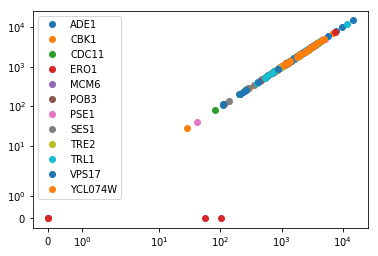

SpearmanrResult(correlation=1.0, pvalue=0.0)


In [13]:
groups = sample_dataframe.groupby('Locus')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.merged_read_count, group.aligned_read_count, marker='o', linestyle='', ms=6, label=name)
    
    
plt.yscale('symlog')
plt.xscale('symlog')
ax.legend()

plt.show()

print(scipy.stats.spearmanr(group.merged_read_count, group.aligned_read_count))

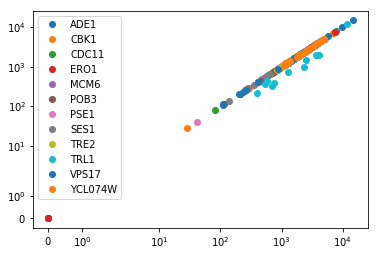

SpearmanrResult(correlation=1.0, pvalue=0.0)


In [14]:
groups = sample_dataframe.groupby('Locus')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.aligned_read_count, group.mut_parse_count, marker='o', linestyle='', ms=6, label=name)
    
    
plt.yscale('symlog')
plt.xscale('symlog')
ax.legend()

plt.show()

print(scipy.stats.spearmanr(group.merged_read_count, group.mut_parse_count))

lets add info on guide sequence to the dataframe

In [15]:
sample_target_dict = {}
sample_target_strand_dict = {}

for Sample_ID in list(sample_dataframe.index):
    
    if Sample_ID in range(1,11):
        sample_target_dict[Sample_ID] = 'GTCAATTACGAAGACTGAAC'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(11,21):
        sample_target_dict[Sample_ID] = 'CATCTCTACCAATTCGTCAC'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(21,31):
        sample_target_dict[Sample_ID] = 'GACTCTATAGAATATTGGCC'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(31,41):
        sample_target_dict[Sample_ID] = 'TATCCTCAGATGTTTCAGTT'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(41,51):
        sample_target_dict[Sample_ID] = 'CCAACTATTTTTCTCACAGT'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(51,61):
        sample_target_dict[Sample_ID] = 'GATCCCAAAAATCCTGGATA'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(61,71):
        sample_target_dict[Sample_ID] = 'TTCACCAAACAACATATTGT'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(71,81):
        sample_target_dict[Sample_ID] = 'CACAGGGATGATGTTAACTA'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(81,91):
        sample_target_dict[Sample_ID] = 'TCTCCGCCACCATCGTCGAT'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(91,101):
        sample_target_dict[Sample_ID] = 'CAACCAATTTATCGAAGATA'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID in range(101,111):
        sample_target_dict[Sample_ID] = 'CTCTCGTTAACAAACCCGGG'
        sample_target_strand_dict[Sample_ID] = '-'
    if Sample_ID in range(111,121):
        sample_target_dict[Sample_ID] = 'TCCATTTGCTGAGCCCCAGG'
        sample_target_strand_dict[Sample_ID] = '+'
    if Sample_ID >=121:
        sample_target_dict[Sample_ID] = 'ATAACGGAATCCAACTGGGC'
        sample_target_strand_dict[Sample_ID] = '-'
    
sample_dataframe['gRNA_seq'] = pd.Series(sample_target_dict)
sample_dataframe['target_strand'] = pd.Series(sample_target_strand_dict)

sample_dataframe.head(10)

,Locus,Type,Well,Timepoint,Replicate,PE1_index,RC_for_index,RC_rev_index,PE2_index,filepath,demult_read_count,merged_read_count,aligned_read_count,mut_parse_count,gRNA_seq,target_strand
Sample_ID,,,,,,,,,,,,,,,,
1,ADE1,locus,A1,T0,1,2,1,1,2,./intermediate_data/demultiplexed_reads/1_inde...,9669,7763,7763,7762,GTCAATTACGAAGACTGAAC,+
2,ADE1,locus,B1,T0,2,2,2,1,2,./intermediate_data/demultiplexed_reads/2_inde...,260,200,200,200,GTCAATTACGAAGACTGAAC,+
3,ADE1,locus,C1,T6,1,2,3,1,2,./intermediate_data/demultiplexed_reads/3_inde...,146,109,109,109,GTCAATTACGAAGACTGAAC,+
4,ADE1,locus,D1,T6,2,2,4,1,2,./intermediate_data/demultiplexed_reads/4_inde...,958,758,758,758,GTCAATTACGAAGACTGAAC,+
5,ADE1,locus,E1,T12,1,2,5,1,2,./intermediate_data/demultiplexed_reads/5_inde...,711,571,571,571,GTCAATTACGAAGACTGAAC,+
6,ADE1,locus,F1,T12,2,2,6,1,2,./intermediate_data/demultiplexed_reads/6_inde...,2147,1755,1755,1755,GTCAATTACGAAGACTGAAC,+
7,ADE1,locus,G1,Plating,1,2,7,1,2,./intermediate_data/demultiplexed_reads/7_inde...,6154,4971,4971,4971,GTCAATTACGAAGACTGAAC,+
8,ADE1,locus,H1,Plating,2,2,8,1,2,./intermediate_data/demultiplexed_reads/8_inde...,11797,9632,9632,9632,GTCAATTACGAAGACTGAAC,+
9,ADE1,locus,I1,can_recov,1,2,9,1,2,./intermediate_data/demultiplexed_reads/9_inde...,3687,3020,3020,3019,GTCAATTACGAAGACTGAAC,+


Let's try and get mutational mapping in a 30 pb windows with the mutagenesis sites centered left

In [16]:
def map_guide_to_wt_seq(Sample_ID):
    
    if sample_dataframe.loc[Sample_ID]['Type'] != 'locus':

        ref_orf = 'CAN1'
        
    else:
        
        ref_orf = sample_dataframe.loc[Sample_ID]['Locus']
        
    
    
    wt_seq = amplicon_dict[ref_orf]
    
    target_strand = sample_dataframe.loc[Sample_ID]['target_strand']
    
    gRNA = sample_dataframe.loc[Sample_ID]['gRNA_seq']
    
    if target_strand == '-':
        
        gRNA = reverse_complement(gRNA)
        
        guide_pos = wt_seq.index(gRNA)
    
        guide_wpam = wt_seq[guide_pos-3:(guide_pos+20)]
    
        sequence_to_map = wt_seq[(guide_pos-6):(guide_pos+24)]
        
    else:
        
        guide_pos = wt_seq.index(gRNA)

        guide_wpam = wt_seq[guide_pos:(guide_pos+23)]

        sequence_to_map = wt_seq[(guide_pos-4):(guide_pos+26)]
    
    
    return guide_pos, guide_wpam, sequence_to_map, target_strand, wt_seq


map_guide_to_wt_seq(11)

(35,
 'CCGGTGACGAATTGGTAGAGATG',
 'CAGCCGGTGACGAATTGGTAGAGATGAGGT',
 '-',
 'ATTTAATATTCAAGATGAAGAGTACCAACCAGCCGGTGACGAATTGGTAGAGATGAGGTTCTATATTCCTGGTGTTATTCAAACAAACGTCGATGAAAACATGACCAAAAAGGAAGAGTCAAGCAACGAGGTCGTACCAAAGAAAGAAGATGGTG')

Function to get overall editing rate in guide window (not allele specific)

In [17]:
def map_muts_along_guide(Sample_ID):
    
    sequenced_alleles = find_mutations(Sample_ID)
       
    guide_pos, guide_wpam, sequence_to_map, target_strand, wt_seq = map_guide_to_wt_seq(Sample_ID)
    
    allele_coverage = sample_dataframe.loc[Sample_ID]['mut_parse_count']
    
    


    to_map_start = int((wt_seq.index(sequence_to_map)))

    to_map_end = int((wt_seq.index(sequence_to_map))+len(sequence_to_map))

    region_to_map = np.arange(to_map_start,to_map_end)

      
    mut_along_pos_counter_dict = {}
    
    wt_nt_dict = {}
       
    for nt in region_to_map:
        
        mut_along_pos_counter_dict[nt] = Counter()
        
        wt_nt_dict[nt] = wt_seq[nt]
        
        for mut_type in ['toG','toC','toT','toA','ins','del']:
            
            mut_along_pos_counter_dict[nt][mut_type] = 0
            
    muts_for_entry = []
    
    for entry in (sequenced_alleles.keys()):
        
        muts_found = sequenced_alleles[entry][0]
        
        align_start = sequenced_alleles[entry][1]
        
        #if align_start != 1:
        #    print('offset')
        # not required to check for any potential offsetting, no detected offsets in any of the alignments used in the experiment
        
        
        for mut in muts_found:
            
            
            if 'ins' in mut:
                
                mut_info=mut.split('ins')
                pos = int(mut_info[0])-1

                if pos in region_to_map:
                    mut_along_pos_counter_dict[pos]['ins'] += 1
                               
            elif 'del' in mut:
                
                mut_info=mut.split('del')
                pos = int(mut_info[0])-1
                
                if pos in region_to_map:
                    mut_along_pos_counter_dict[pos]['ins'] += 1
                
            else:
                
                mut_info=mut.split('|')
                pos = int(mut_info[1])-1
                mut_to ='to'+mut_info[2]

                
                if pos in region_to_map:
                    mut_along_pos_counter_dict[pos][mut_to] += 1
                
    
    sample_df = pd.DataFrame.from_dict(mut_along_pos_counter_dict, orient = 'index')
    sample_df = sample_df/allele_coverage
    
    sample_df['wt_nt'] = pd.Series(wt_nt_dict)
    sample_df['edit_rate'] = sample_df['toG']+sample_df['toC']+sample_df['toT']+sample_df['toA']+sample_df['ins']+sample_df['del']
    
    
    
    return sample_df

In [19]:
def get_timecourse_allele_total_edit_rates(locus, target):
    
    select_samples_by_locus = sample_dataframe['Locus'] == locus
    select_samples_by_target = sample_dataframe['Type'] == target
    
    select_samples = select_samples_by_locus & select_samples_by_target
    
    Sample_ID_list = sorted(list(sample_dataframe[select_samples].index))
    
    print(Sample_ID_list)
    
    output_df_list = []  
    
    for Sample_ID in Sample_ID_list:
        
        Timepoint = sample_dataframe.loc[Sample_ID]['Timepoint']
        Replicate = sample_dataframe.loc[Sample_ID]['Replicate']
        
        sample_seq_result = map_muts_along_guide(Sample_ID)
        
        col_rename_dict = {}
        
        for col_name in ['toG','toC','toT','toA','ins','del','wt_nt','edit_rate']:
            
            col_rename_dict[col_name] = col_name+'_'+Timepoint+'_'+str(Replicate)
            
        sample_seq_result.rename(mapper=col_rename_dict, axis = 1, inplace=True)
        
        output_df_list.append(sample_seq_result)
        
    output_df = pd.concat(output_df_list,axis=1)
        
    file_out_name = './results/overall_editing_rate/'+locus+'_'+target+'.csv'
    
    output_df.to_csv(file_out_name, sep = ',')
    
    
    
    
    return output_df

get_timecourse_allele_total_edit_rates('ERO1', 'CAN1')
    

[181, 182, 183, 184, 185, 186, 187, 188, 189, 190]


,toG_T0_1,toC_T0_1,toT_T0_1,toA_T0_1,ins_T0_1,del_T0_1,wt_nt_T0_1,edit_rate_T0_1,toG_T0_2,toC_T0_2,...,wt_nt_can_recov_1,edit_rate_can_recov_1,toG_can_recov_2,toC_can_recov_2,toT_can_recov_2,toA_can_recov_2,ins_can_recov_2,del_can_recov_2,wt_nt_can_recov_2,edit_rate_can_recov_2
74,0.000000,0.000430,0.000000,0.000430,0.0,0.0,T,0.000861,0.000000,0.000000,...,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,NaN
75,0.000000,0.000000,0.000000,0.000000,0.0,0.0,T,0.000000,0.000000,0.000000,...,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,NaN
76,0.000000,0.000000,0.000000,0.000000,0.0,0.0,A,0.000000,0.000000,0.000000,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN
77,0.000000,0.000000,0.000000,0.000000,0.0,0.0,C,0.000000,0.000000,0.000000,...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN
78,0.000000,0.000000,0.000861,0.000000,0.0,0.0,C,0.000861,0.000000,0.000000,...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN
79,0.000000,0.000000,0.000000,0.000000,0.0,0.0,G,0.000000,0.000000,0.000000,...,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,NaN
80,0.000000,0.000000,0.000000,0.001721,0.0,0.0,G,0.001721,0.000000,0.000000,...,G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,NaN
81,0.000000,0.000000,0.000430,0.000000,0.0,0.0,C,0.000430,0.000000,0.000000,...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN
82,0.000861,0.000000,0.000861,0.000000,0.0,0.0,C,0.001721,0.000497,0.000000,...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN
83,0.000000,0.000000,0.000430,0.000000,0.0,0.0,C,0.000430,0.000000,0.000000,...,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN


In [20]:
for locus in list(sample_dataframe.Locus.unique()):
    
    for target in ['locus', 'CAN1']:
        
        get_timecourse_allele_total_edit_rates(locus, target)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[121, 122, 123, 124, 125, 126, 127, 128, 129, 130]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[131, 132, 133, 134, 135, 136, 137, 138, 139, 140]
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
[31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
[151, 152, 153, 154, 155, 156, 157, 158, 159, 160]
[41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[161, 162, 163, 164, 165, 166, 167, 168, 169, 170]
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
[171, 172, 173, 174, 175, 176, 177, 178, 179, 180]
[61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
[181, 182, 183, 184, 185, 186, 187, 188, 189, 190]
[71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[191, 192, 193, 194, 195, 196, 197, 198, 199, 200]
[81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
[201, 202, 203, 204, 205, 206, 207, 208, 209, 210]
[91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[211, 212, 213, 214, 215, 216, 217, 218, 219, 220]
[101, 102, 103, 104, 105, 106, 107, 108, 109, 110]
[221, 222, 223, 224, 225, 226, 227, 2

([0.01919608348363824,
  0.009174311926605505,
  0.2329246935201401,
  0.8310199155099578,
  0.7946339847631665],
 [0.015,
  0.03034300791556728,
  0.23874643874643875,
  0.7523878737541528,
  0.7909698996655519])

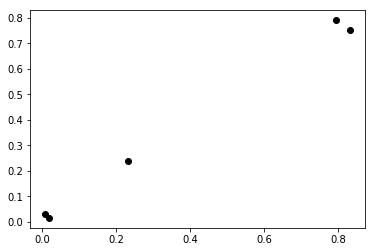

In [51]:
def get_corr_coeff_total_edit_rates(locus, target, nt_list, color, plot=True):
    
    csv_path = './results/overall_editing_rate/'+locus+'_'+target+'.csv'
    
    edit_rate_df = pd.read_csv(csv_path, index_col = 0)
    
    rep_1_vals = []
    rep_2_vals = []
    
    for pos in nt_list:
        
        for timepoint in ['T0', 'T6', 'T12', 'Plating', 'can_recov']:
            
            for rep in ['_1', '_2']:
                
                if rep == '_1':
                    
                    col_name = 'edit_rate_'+timepoint+rep
                    rep_1_vals.append(edit_rate_df.loc[pos][col_name])
                    
                elif rep == '_2':
                    
                    col_name = 'edit_rate_'+timepoint+rep
                    rep_2_vals.append(edit_rate_df.loc[pos][col_name])
                    
    if plot == True:
        
        plt.plot(rep_1_vals,rep_2_vals, marker = 'o', color = color, linestyle='none')

    
    return rep_1_vals, rep_2_vals



get_corr_coeff_total_edit_rates('ADE1', 'locus', [43], 'black')

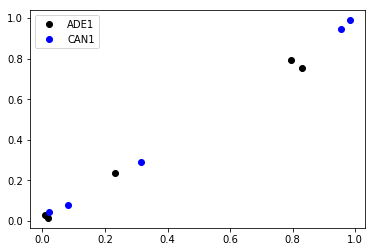

In [52]:
get_corr_coeff_total_edit_rates('ADE1', 'locus', [43], 'black')
get_corr_coeff_total_edit_rates('ADE1', 'CAN1', [95], 'blue')

plt.legend(['ADE1', 'CAN1'])

In [53]:
locus_edit_site_list_dict = {'ADE1': [43],
                             #+       18
                             'POB3':[49, 51, 54],
                             #-      15  17  20
                             'CBK1':[70, 72],
                             #-      16  18
                             'TRE2':[73, 75, 76],
                             #-      14  16  17  
                             'TRL1':[91, 94, 95],
                             #-      16  19  20
                             'PSE1':[97, 98, 99],
                             #+      17  16  15
                             'ERO1':[69, 71, 72],
                             #+      18  16  15
                             'CDC11':[99, 101],
                             #-       18  20
                             'MCM6':[88, 90, 91, 93],
                             #+      19  17  16  14
                             'SES1':[50, 53, 54],
                             #+      20  16  17
                             'YCL074W':[83, 85, 87],
                             #-         16  18  20
                             'VPS17':[77, 78],
                             #        19  18
                             'CAN1':[95]
                             #       16
                             }

SpearmanrResult(correlation=0.9225955805492603, pvalue=5.263099785186655e-66)
SpearmanrResult(correlation=0.9827763080039661, pvalue=8.275913318165462e-54)
160
69
SpearmanrResult(correlation=0.9307422559906487, pvalue=1.408087469069058e-26)
SpearmanrResult(correlation=0.9269993164730006, pvalue=1.1668677910498625e-24)
60
53


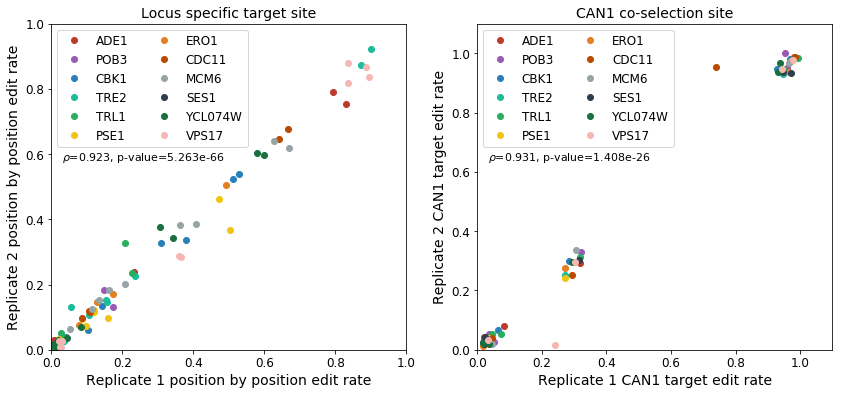

In [54]:
plt.figure(figsize = (14,6))

plt.subplot(121)

######### For locus sequencing

colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']


alleles_plotted = []

all_rep_1 = []
all_rep_2 = []

for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
        
    pos_list = locus_edit_site_list_dict[locus]
    
    edit_rates = get_corr_coeff_total_edit_rates(locus, 'locus', pos_list, colors[x])
    
    all_rep_1 += edit_rates[0]
    all_rep_2 += edit_rates[1]
    
    alleles_plotted.append(locus)
    
plt.xlim(0,1)
plt.ylim(0,1)

plt.legend(alleles_plotted, loc='upper left', fontsize=12, ncol =2)
plt.text(0.03, 0.58, r'$\rho$=0.923, p-value=5.263e-66', fontsize = 11)

rep1_array = pd.Series(all_rep_1)
rep2_array = pd.Series(all_rep_2)

plt.xticks(fontsize=12)
plt.yticks(fontsize =12)
    
print(scipy.stats.spearmanr(rep1_array, rep2_array, nan_policy='omit'))   

print(scipy.stats.spearmanr(rep1_array.mask(rep1_array < 0.02), rep2_array.mask(rep1_array < 0.02), nan_policy='omit'))

n_sites_test_2 = 0

print(len(all_rep_1))

for x in range(0,len(all_rep_1)):
    
    if all_rep_1[x] > 0.02 and all_rep_2[x] > 0.02:
        
        n_sites_test_2 += 1
        
        
print (n_sites_test_2)


plt.title('Locus specific target site', fontsize=14)
plt.ylabel('Replicate 2 position by position edit rate', fontsize = 14)
plt.xlabel('Replicate 1 position by position edit rate', fontsize = 14)



plt.subplot(122)

######### For CAN1 sequencing

colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']


alleles_plotted = []

all_rep_1 = []
all_rep_2 = []

for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
        
    pos_list = locus_edit_site_list_dict['CAN1']
    
    edit_rates = get_corr_coeff_total_edit_rates(locus, 'CAN1', pos_list, colors[x])
    
    all_rep_1 += edit_rates[0]
    all_rep_2 += edit_rates[1]
    
    alleles_plotted.append(locus)
    
plt.xlim(0,1.1)
plt.ylim(0,1.1)

plt.legend(alleles_plotted, loc='upper left', fontsize=12, ncol =2)



rep1_array = pd.Series(all_rep_1)
rep2_array = pd.Series(all_rep_2)
    
print(scipy.stats.spearmanr(rep1_array, rep2_array, nan_policy='omit'))   

print(scipy.stats.spearmanr(rep1_array.mask(rep1_array < 0.02), rep2_array.mask(rep1_array < 0.02), nan_policy='omit'))

n_sites_test_2 = 0

print(len(all_rep_1))

for x in range(0,len(all_rep_1)):
    
    if all_rep_1[x] > 0.02 and all_rep_2[x] > 0.02:
        
        n_sites_test_2 += 1
        
        
print (n_sites_test_2)

plt.text(0.033, 0.64, r'$\rho$=0.931, p-value=1.408e-26', fontsize = 11)

plt.title('CAN1 co-selection site', fontsize=14)
plt.ylabel('Replicate 2 CAN1 target edit rate', fontsize = 14)
plt.xlabel('Replicate 1 CAN1 target edit rate', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize =12)

plt.savefig('./pos_by_pos_mut_rate_correlation.png', format='png', dpi=600)

## plot CAN1 mutation rate dristribution from average

0.7901499005913025
0.352106113878059
0.07430177716640197
0.013013873900848365
0.030449307612460758


(0, 1.1)

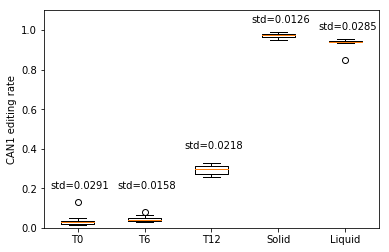

In [55]:
all_rep_1 = []
all_rep_2 = []


for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
        
    pos_list = locus_edit_site_list_dict['CAN1']
    
    edit_rates = get_corr_coeff_total_edit_rates(locus, 'CAN1', pos_list, colors[x], plot=False)
    
    all_rep_1 += edit_rates[0]
    all_rep_2 += edit_rates[1]
    
    alleles_plotted.append(locus)


average_CAN1 = [(all_rep_1[x]+all_rep_2[x])/2 for x in range(0,len(all_rep_1))]

T0_indexes = [x for x in range(0,60, 5)]
T0_values = [average_CAN1[x] for x in T0_indexes]

T6_indexes = [x+1 for x in range(0,60, 5)]
T6_values = [average_CAN1[x] for x in T6_indexes]

T12_indexes = [x+2 for x in range(0,60, 5)]
T12_values = [average_CAN1[x] for x in T12_indexes]

solid_indexes = [x+3 for x in range(0,60, 5)]
solid_values = [average_CAN1[x] for x in solid_indexes]

liquid_indexes = [x+4 for x in range(0,60, 5)]
liquid_values = [average_CAN1[x] for x in liquid_indexes if x != 34]


print(stats.variation(T0_values))
print(stats.variation(T6_values))
print(stats.variation(T12_values))
print(stats.variation(solid_values))
print(stats.variation(liquid_values))

plt.boxplot([T0_values, T6_values, T12_values, solid_values, liquid_values])

plt.text(0.6, 0.2, ('std='+str(round(np.std(T0_values), 4))))
plt.text(1.6, 0.2, ('std='+str(round(np.std(T6_values), 4))))
plt.text(2.6, 0.4, ('std='+str(round(np.std(T12_values), 4))))
plt.text(3.6, 1.04, ('std='+str(round(np.std(solid_values), 4))))
plt.text(4.6, 1.0, ('std='+str(round(np.std(liquid_values), 4))))






plt.ylabel('CAN1 editing rate')
plt.xticks([1,2,3,4,5], ['T0', 'T6', 'T12', 'Solid', 'Liquid'])

plt.ylim(0,1.1)
    

In [56]:
alleles_plotted = []

all_rep_1 = []
all_rep_2 = []


for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
        
    pos_list = locus_edit_site_list_dict['CAN1']
    
    edit_rates = get_corr_coeff_total_edit_rates(locus, 'CAN1', pos_list, colors[x], plot=False)
    
    all_rep_1 += edit_rates[0]
    all_rep_2 += edit_rates[1]
    
    alleles_plotted.append(locus)


average_CAN1 = [(all_rep_1[x]+all_rep_2[x])/2 for x in range(0,len(all_rep_1))]

SpearmanrResult(correlation=0.9307422559906487, pvalue=1.408087469069058e-26)
SpearmanrResult(correlation=0.9269993164730006, pvalue=1.1668677910498625e-24)
60
53


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text yticklabel objects>)

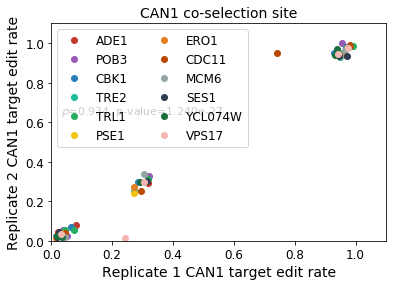

In [57]:

colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']


alleles_plotted = []

all_rep_1 = []
all_rep_2 = []

for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
        
    pos_list = locus_edit_site_list_dict['CAN1']
    
    edit_rates = get_corr_coeff_total_edit_rates(locus, 'CAN1', pos_list, colors[x])
    
    all_rep_1 += edit_rates[0]
    all_rep_2 += edit_rates[1]
    
    alleles_plotted.append(locus)
    
plt.xlim(0,1.1)
plt.ylim(0,1.1)

plt.legend(alleles_plotted, loc='upper left', fontsize=12, ncol =2)



rep1_array = pd.Series(all_rep_1)
rep2_array = pd.Series(all_rep_2)
    
print(scipy.stats.spearmanr(rep1_array, rep2_array, nan_policy='omit'))   

print(scipy.stats.spearmanr(rep1_array.mask(rep1_array < 0.02), rep2_array.mask(rep1_array < 0.02), nan_policy='omit'))

n_sites_test_2 = 0

print(len(all_rep_1))

for x in range(0,len(all_rep_1)):
    
    if all_rep_1[x] > 0.02 and all_rep_2[x] > 0.02:
        
        n_sites_test_2 += 1
        
        
print (n_sites_test_2)

plt.text(0.033, 0.64, r'$\rho$=0.934, p-value=1.240e-27', fontsize = 11)

plt.title('CAN1 co-selection site', fontsize=14)
plt.ylabel('Replicate 2 CAN1 target edit rate', fontsize = 14)
plt.xlabel('Replicate 1 CAN1 target edit rate', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize =12)

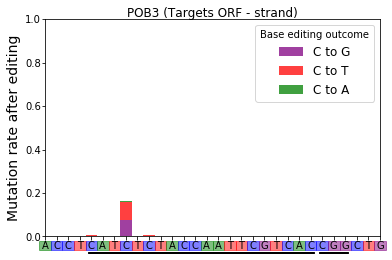

In [58]:
def plot_mut_product_split_by_pos(Sample_ID, timepoint):
    
    locus = sample_dataframe.loc[Sample_ID]['Locus']
    target = sample_dataframe.loc[Sample_ID]['Type']
    strand = sample_target_strand_dict[Sample_ID]
    
    csv_path = './results/overall_editing_rate/'+locus+'_'+target+'.csv'
    
    data_df = pd.read_csv(csv_path, sep=',', index_col =0)
    
    cols_list = ['toG', 'toC', 'toT', 'toA', 'ins', 'del', 'wt_nt', 'edit_rate']
    
    rep_1_cols = [(x+'_'+timepoint+'_1') for x in cols_list]
    rep_2_cols = [(x+'_'+timepoint+'_2') for x in cols_list]

    rep_1_df = data_df[rep_1_cols]
    rep_2_df = data_df[rep_2_cols]
    
    avg_df = pd.DataFrame(index=rep_1_df.index)
    
    for x in range(0, len(cols_list)):
        
        col_name = cols_list[x]
        
        if cols_list[x] in ['toG', 'toC', 'toT', 'toA', 'ins', 'del', 'edit_rate']:
            
            avg_df[cols_list[x]] = (rep_1_df[rep_1_cols[x]] + rep_2_df[rep_2_cols[x]])/2
            
        else:
                         
            avg_df[cols_list[x]] = rep_1_df[rep_1_cols[x]]
            
    if strand == '+':            
            
        p1 = plt.bar(avg_df.index, avg_df.toG, 1, color = 'purple', align='center', alpha = 0.75)
        p2 = plt.bar(avg_df.index, avg_df.toT, 1, bottom=avg_df.toG, color = 'red', align='center', alpha=0.75)
        p2 = plt.bar(avg_df.index, avg_df.toA, 1, bottom=np.array(avg_df.toG)+np.array(avg_df.toT), color = 'green', align='center', alpha = 0.75)
        
        plt.legend(title='Base editing outcome', labels = ['C to G', 'C to T', 'C to A'], fontsize = 12, loc = 'upper right')
        
        

    
    elif strand == '-':
        p1 = plt.bar(list(avg_df.index)[::-1], avg_df.toC, 1, color = 'purple', align='center', alpha = 0.75)
        p2 = plt.bar(list(avg_df.index)[::-1], avg_df.toA, 1, bottom=avg_df.toC, color = 'red', align='center', alpha = 0.75)
        p2 = plt.bar(list(avg_df.index)[::-1], avg_df.toT, 1, bottom=np.array(avg_df.toC)+np.array(avg_df.toA), color = 'green', align='center', alpha = 0.75)
        
        plt.legend(title='Base editing outcome', labels = ['C to G', 'C to T', 'C to A'],loc = 'upper right', fontsize = 12)
        
        #plt.axvspan(min(avg_df.index)+2.75, max(avg_df.index)-23.75, -0.073,-0.075, color = 'k', clip_on=False, zorder =9)
        #plt.axvspan(min(avg_df.index)+5.75, max(avg_df.index)-3.75, -0.073,-0.075, color = 'k', clip_on=False, zorder =9)
        
    plt.axvspan(min(avg_df.index)+3.75, max(avg_df.index)-5.75, -0.073,-0.075, color = 'k', clip_on=False, zorder =9)
    plt.axvspan(min(avg_df.index)+23.75, max(avg_df.index)-2.75, -0.073,-0.075, color = 'k', clip_on=False, zorder =9)
        
    if strand == '-':
        
        for nt in [x for x in list(avg_df.index)[::-1]]:
            
            nt_pos = list(avg_df.index)[::-1].index(nt)
            
            #print(avg_df.loc[nt]['wt_nt'], reverse_complement(avg_df.loc[nt]['wt_nt']))
            
            if reverse_complement(avg_df.loc[nt]['wt_nt']) == 'A':
                color = 'green'
            if reverse_complement(avg_df.loc[nt]['wt_nt']) == 'T':
                color = 'red'
            if reverse_complement(avg_df.loc[nt]['wt_nt']) == 'C':
                color = 'blue'
            if reverse_complement(avg_df.loc[nt]['wt_nt']) == 'G':
                color = 'purple'

            plt.axvspan((list(avg_df.index)[nt_pos]-0.5), (list(avg_df.index)[nt_pos]+0.5), -0.02, -0.06, color = color, alpha = 0.5,  
                                                           clip_on = False)

    else:
                
        for nt in [x for x in list(avg_df.index)]:
            
            if avg_df.loc[nt]['wt_nt'] == 'A':
                color = 'green'
            if avg_df.loc[nt]['wt_nt'] == 'T':
                color = 'red'
            if avg_df.loc[nt]['wt_nt'] == 'C':
                color = 'blue'
            if avg_df.loc[nt]['wt_nt'] == 'G':
                color = 'purple'

            plt.axvspan((nt-0.5), (nt+0.5), -0.02, -0.06, color = color, alpha = 0.5,  clip_on = False)
        
    plt.ylim(0,1)
    plt.xlim(min(avg_df.index), max(avg_df.index))
    
    if strand == '-':
        
        plt.xticks(list(avg_df.index), [reverse_complement(avg_df.loc[x]['wt_nt']) for x in list(avg_df.index)[::-1]])
        
        #print([avg_df.loc[x]['wt_nt'] for x in avg_df.index])
        #print([avg_df.loc[x]['wt_nt'] for x in list(avg_df.index)[::-1]])
        #print([reverse_complement(avg_df.loc[x]['wt_nt']) for x in list(avg_df.index)[::-1]])

    else:
        
        plt.xticks(avg_df.index, [avg_df.loc[x]['wt_nt'] for x in avg_df.index])

        
        
    plt.tick_params(pad = 0.55)
    #plt.xlabel('Target sequence', fontsize = 12, zorder =1, labelpad = 4)
    plt.ylabel('Mutation rate after editing', fontsize =14)
    plt.title((locus+' (Targets ORF '+strand+' strand)'), fontsize = 12, pad = 2)

    
    
plot_mut_product_split_by_pos(19, 'can_recov')

In [59]:
a = [1,2,3]

[x for x in a[::-1]]

[3, 2, 1]

In [60]:
reverse_complement('A')

'T'

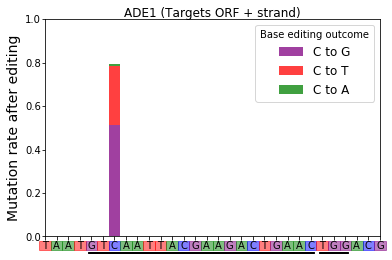

In [61]:
plot_mut_product_split_by_pos(9, 'can_recov')

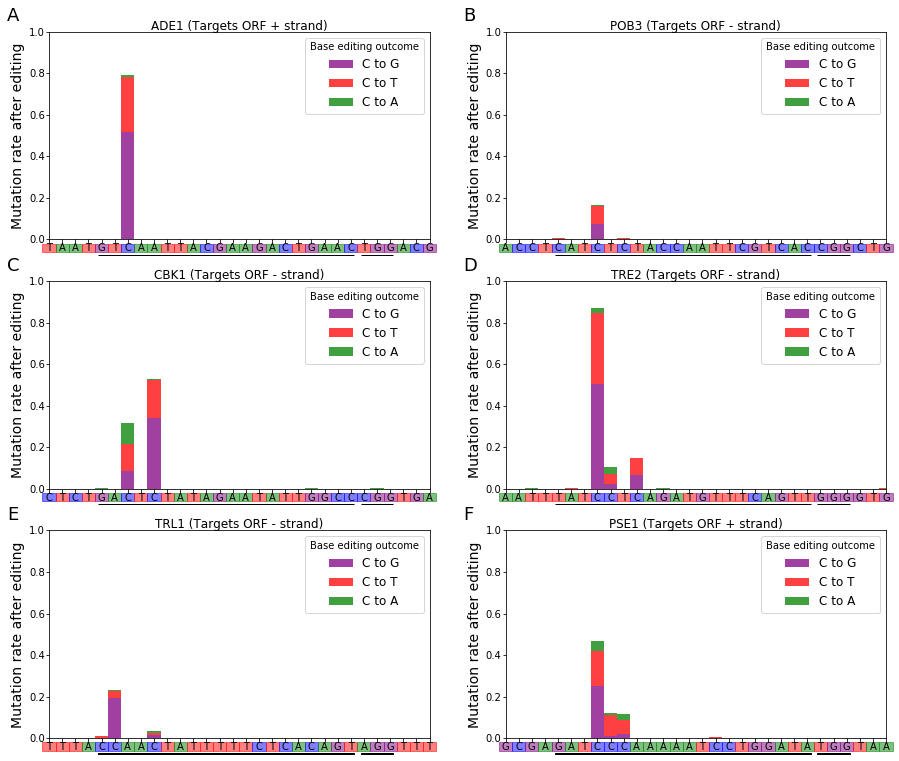

In [62]:
plt.figure(figsize = (15,13))

ax1 = plt.subplot(321)

plot_mut_product_split_by_pos(9, 'can_recov')
plt.text(-0.11, 1.05, 'A', transform = ax1.transAxes, fontsize = 18)

plt.subplot(322)
ax2 = plot_mut_product_split_by_pos(19, 'can_recov')
plt.text(1.09, 1.05, 'B', transform = ax1.transAxes, fontsize = 18)


ax3 = plt.subplot(323)
plot_mut_product_split_by_pos(29, 'can_recov')
plt.text(-0.11, 1.05, 'C', transform = ax3.transAxes, fontsize = 18)


plt.subplot(324)
ax4 = plot_mut_product_split_by_pos(39, 'can_recov')
plt.text(1.09, 1.05, 'D', transform = ax3.transAxes, fontsize = 18)


ax5 = plt.subplot(325)
plot_mut_product_split_by_pos(49, 'can_recov')
plt.text(-0.11, 1.05, 'E', transform = ax5.transAxes, fontsize = 18)


plt.subplot(326)
ax6 = plot_mut_product_split_by_pos(59, 'can_recov')
plt.text(1.09, 1.05, 'F', transform = ax5.transAxes, fontsize = 18)

plt.savefig('./mutation_outcome1to6.svg', format = 'svg', dpi = 600)

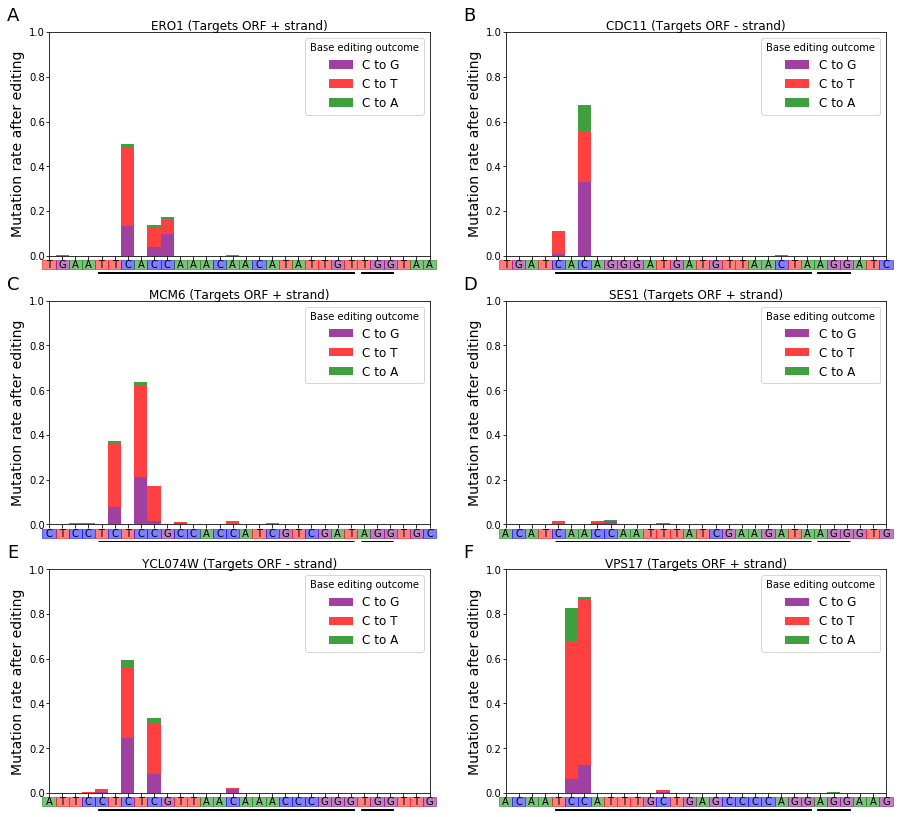

In [63]:
plt.figure(figsize = (15,14))

ax1 = plt.subplot(321)
plot_mut_product_split_by_pos(68, 'Plating')
plt.text(-0.11, 1.05, 'A', transform = ax1.transAxes, fontsize = 18)


plt.subplot(322)
plot_mut_product_split_by_pos(79, 'can_recov')
plt.text(1.09, 1.05, 'B', transform = ax1.transAxes, fontsize = 18)



ax3 = plt.subplot(323)
plot_mut_product_split_by_pos(89, 'can_recov')
plt.text(-0.11, 1.05, 'C', transform = ax3.transAxes, fontsize = 18)


plt.subplot(324)
plot_mut_product_split_by_pos(99, 'can_recov')
plt.text(1.09, 1.05, 'D', transform = ax3.transAxes, fontsize = 18)


ax5 = plt.subplot(325)
plot_mut_product_split_by_pos(109, 'can_recov')
plt.text(-0.11, 1.05, 'E', transform = ax5.transAxes, fontsize = 18)


plt.subplot(326)
plot_mut_product_split_by_pos(119, 'can_recov')
plt.text(1.09, 1.05, 'F', transform = ax5.transAxes, fontsize = 18)


plt.savefig('./mutation_outcome7to12.svg', format = 'svg', dpi = 600)

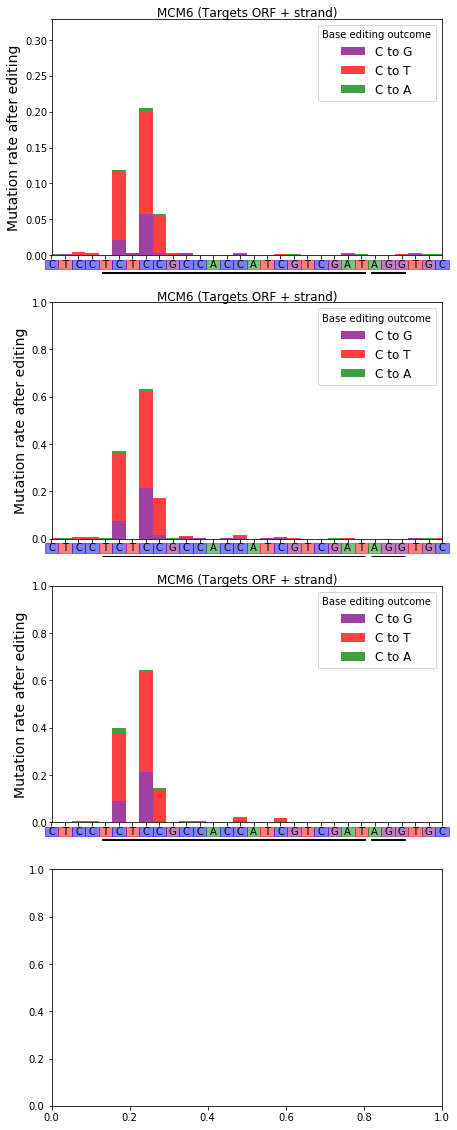

In [64]:
plt.figure(figsize = (7,20))

plt.subplot(411)
plot_mut_product_split_by_pos(81, 'T12')
plt.ylim(0,0.33)

plt.subplot(412)
plot_mut_product_split_by_pos(81, 'can_recov')

plt.subplot(413)
plot_mut_product_split_by_pos(81, 'Plating')

plt.subplot(414)



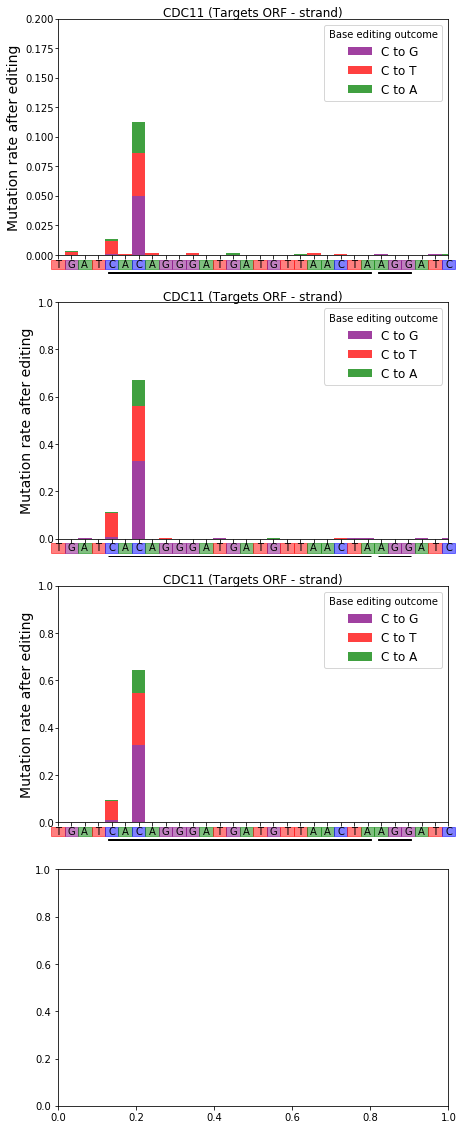

In [65]:
plt.figure(figsize = (7,20))

plt.subplot(411)
plot_mut_product_split_by_pos(71, 'T12')
plt.ylim(0, 0.20)

plt.subplot(412)
plot_mut_product_split_by_pos(71, 'can_recov')

plt.subplot(413)
plot_mut_product_split_by_pos(71, 'Plating')

plt.subplot(414)

In [82]:
def get_mut_prop_data_points(Sample_ID, timepoint):
    
    locus = sample_dataframe.loc[Sample_ID]['Locus']
    target = sample_dataframe.loc[Sample_ID]['Type']
    strand = sample_target_strand_dict[Sample_ID]
    
    csv_path = './results/overall_editing_rate/'+locus+'_'+target+'.csv'
    
    data_df = pd.read_csv(csv_path, sep=',', index_col =0)
    
    cols_list = ['toG', 'toC', 'toT', 'toA', 'ins', 'del', 'wt_nt', 'edit_rate']
    
    rep_1_cols = [(x+'_'+timepoint+'_1') for x in cols_list]
    rep_2_cols = [(x+'_'+timepoint+'_2') for x in cols_list]

    rep_1_df = data_df[rep_1_cols]
    rep_2_df = data_df[rep_2_cols]
    
    avg_df = pd.DataFrame(index=rep_1_df.index)
        
    for x in range(0, len(cols_list)):

        col_name = cols_list[x]

        if cols_list[x] in ['toG', 'toC', 'toT', 'toA', 'ins', 'del', 'edit_rate']:

            avg_df[cols_list[x]] = (rep_1_df[rep_1_cols[x]] + rep_2_df[rep_2_cols[x]])/2

        else:

            avg_df[cols_list[x]] = rep_1_df[rep_1_cols[x]]
            
            
    
    site_list = locus_edit_site_list_dict[locus]
    # get edit sites
    
    
    
    to_G_dict = {}
    to_T_dict = {}
    to_A_dict = {}
            
    
    for site in site_list:
        
        site_edit_rate = avg_df.loc[site]['edit_rate']
        
        if site_edit_rate >= 0.01:
        
            if strand == '-':

                to_G = avg_df.loc[site]['toC']
                to_T = avg_df.loc[site]['toA']
                to_A = avg_df.loc[site]['toT']

            else:

                to_G = avg_df.loc[site]['toG']
                to_T = avg_df.loc[site]['toT']
                to_A = avg_df.loc[site]['toA']

            to_G_dict[site] = to_G/site_edit_rate
            to_T_dict[site] = to_T/site_edit_rate
            to_A_dict[site] = to_A/site_edit_rate

    out_dict = {'toG':to_G_dict, 'toT':to_T_dict, 'toA':to_A_dict}
    
    return out_dict

        
            
            
            
    

In [83]:
get_mut_prop_data_points(29, 'can_recov')

{'toG': {70: 0.6334677360027073, 72: 0.27093451746036523},
 'toT': {70: 0.3441354441141418, 72: 0.400858692409554},
 'toA': {70: 0.009825276529813916, 72: 0.3255658978282659}}

30
0.2896224283991701 0.5504227079179058 0.9329347151509941 0.05390435305424664
WilcoxonResult(statistic=112.0, pvalue=0.01319416986541395)
WilcoxonResult(statistic=41.0, pvalue=8.187753439649276e-05)
WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
[0.01238599044431457, 0.033685581933989586, 0.009825276529813916, 0.3255658978282659, 0.028133081047965088, 0.3355098960540529, 0.025999734832541508, 0.19370322160754963, 0.01581847265833284, 0.11357671200190886, 0.09731943763750454, 0.08754787246914321, 0.23966893994397226, 0.03065607401656527, 0.07817612895720419, 0.03841256550095714, 0.16907410121538805, 0.026368337181696965, 0.03233537434044143, 0.02552718448666291, 0.016266919451216038, 0.026554425409249398, 0.05550502294180664, 0.23528693102485343, 0.1137766776519349, 0.07726339791723345, 0.05230368316668664, 0.1010077715021713, 0.1790305848041389, 0.011658715292730062]
[0.3389567975004445, 0.5086421540243197, 0.3441354441141418, 0.400858692409554, 0.5153091770815944, 0.44

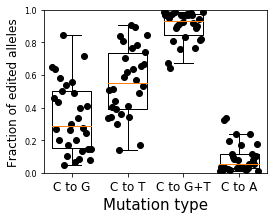

In [102]:
colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']

plt.figure(figsize = (4,3))

n_pos = 0

to_G_list = []
to_T_list = []
to_A_list = []

n_site_list = []

for sample_ID in [9,19,29,39,49,59,67,79,89,99,109,119]:
    
    if sample_ID == 67:
        
        site_prop_dict = get_mut_prop_data_points(sample_ID, 'Plating')
        
    else:
        
        site_prop_dict = get_mut_prop_data_points(sample_ID, 'can_recov')
        
    to_G_list += site_prop_dict['toG'].values()
    to_T_list += site_prop_dict['toT'].values()
    to_A_list += site_prop_dict['toA'].values()
    
    n_pos += len(site_prop_dict['toG'].values())
    n_site_list.append(len(site_prop_dict['toG'].values()))
    
    
ToGorT = [(to_G_list[x]+to_T_list[x]) for x in range(0, len(to_G_list))]
    
plt.boxplot([to_G_list, to_T_list, ToGorT , to_A_list], positions = [1,2,3,4], widths = 0.7, showfliers=False)
print(n_pos)

data_point_x = list(np.arange(0.65, 1.35,0.024))

for x in data_point_x:
    
    plt.plot(x, to_G_list[data_point_x.index(x)], 'ko')
    plt.plot(x+1, to_T_list[data_point_x.index(x)], 'ko')
    plt.plot(x+2, ToGorT[data_point_x.index(x)], 'ko')
    plt.plot(x+3, to_A_list[data_point_x.index(x)], 'ko')
    
plt.ylim(0,1)
plt.ylabel('Fraction of edited alleles', fontsize = 12)
plt.yticks(fontsize=8)

plt.xticks([1,2,3,4], ['C to G', 'C to T', 'C to G+T', 'C to A'], fontsize = 12)

plt.xlabel('Mutation type', fontsize = 15)

print(np.median(to_G_list), np.median(to_T_list), np.median(ToGorT), np.median(to_A_list))


print(scipy.stats.wilcoxon(to_G_list, to_T_list))
print(scipy.stats.wilcoxon(to_G_list, to_A_list))
print(scipy.stats.wilcoxon(to_T_list, to_A_list))
print(to_A_list)
print(to_T_list)

plt.savefig('./nucleotide_level_outcomes.png', format = 'png', dpi = 600)



In [85]:
import pickle as pl

In [86]:
data_panel_D = [to_G_list, to_T_list, ToGorT, to_A_list]

with open('./pickled_objects/fig2_panel_D_data.pickle', 'wb') as out:
    
    pl.dump(data_panel_D, out)

In [87]:
a = [1,2]

b = [3,4]

print(a+b)

[1, 2, 3, 4]


In [88]:
def get_mut_prop_data_points_normalized(Sample_ID, timepoint):
    
    locus = sample_dataframe.loc[Sample_ID]['Locus']
    target = sample_dataframe.loc[Sample_ID]['Type']
    strand = sample_target_strand_dict[Sample_ID]
    
    csv_path = './results/overall_editing_rate/'+locus+'_'+target+'.csv'
    
    data_df = pd.read_csv(csv_path, sep=',', index_col =0)
    
    cols_list = ['toG', 'toC', 'toT', 'toA', 'ins', 'del', 'wt_nt', 'edit_rate']
    
    rep_1_cols = [(x+'_'+timepoint+'_1') for x in cols_list]
    rep_2_cols = [(x+'_'+timepoint+'_2') for x in cols_list]

    rep_1_df = data_df[rep_1_cols]
    rep_2_df = data_df[rep_2_cols]
    
    avg_df = pd.DataFrame(index=rep_1_df.index)
        
    for x in range(0, len(cols_list)):

        col_name = cols_list[x]

        if cols_list[x] in ['toG', 'toC', 'toT', 'toA', 'ins', 'del', 'edit_rate']:

            avg_df[cols_list[x]] = (rep_1_df[rep_1_cols[x]] + rep_2_df[rep_2_cols[x]])/2

        else:

            avg_df[cols_list[x]] = rep_1_df[rep_1_cols[x]]
            
            
    
    site_list = locus_edit_site_list_dict[locus]
    # get edit sites
    
    
    
    to_G_dict = {}
    to_T_dict = {}
    to_A_dict = {}
            
    
    for site in site_list:
        
        site_edit_rate = avg_df.loc[site]['edit_rate']
        
        if site_edit_rate >= 0.01:
        
            if strand == '-':

                to_G = avg_df.loc[site]['toC']
                to_T = avg_df.loc[site]['toA']
                to_A = avg_df.loc[site]['toT']

            else:

                to_G = avg_df.loc[site]['toG']
                to_T = avg_df.loc[site]['toT']
                to_A = avg_df.loc[site]['toA']

            to_G_dict[site] = to_G*site_edit_rate
            to_T_dict[site] = to_T*site_edit_rate
            to_A_dict[site] = to_A*site_edit_rate

    out_dict = {'toG':to_G_dict, 'toT':to_T_dict, 'toA':to_A_dict}
    
    return out_dict

        
            
            
            
    

30
0.014533747382953516 0.013036389300410987 0.02912007636915532 0.0021322169008738774
WilcoxonResult(statistic=162.0, pvalue=0.1470395786434527)
WilcoxonResult(statistic=58.0, pvalue=0.00033172583107637916)
WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
[0.21304618345764986, 0.013848223666032148, 0.09812592905568993, 0.04061918565087114, 0.012186936223175446, 0.005138326628510437, 0.2972332687523248, 0.00034674278516779616, 0.007690599880437136, 0.00011214492483128432, 0.07860372375708449, 0.01190186840814512, 0.00820599691958609, 0.17575478677210804, 0.011601776203454475, 0.012224554934789827, 0.15441088145696757, 0.011443301124716034, 0.10591358690648926, 0.25698145539845707, 0.026872646526407525, 9.370372472935557e-05, 0.00015305745168255465, 0.00012748504195440622, 6.658986902728814e-05, 0.07679614193183268, 0.1902549825765211, 0.00020324562674943735, 0.507339724699816, 0.648891183808955]
[0.007785027507821788, 0.0009171191755373768, 0.0028015550394666147, 0.03298973

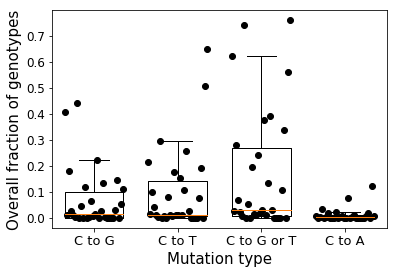

In [100]:
n_pos = 0

to_G_list = []
to_T_list = []
to_A_list = []

n_site_list = []

for sample_ID in [9,19,29,39,49,59,67,79,89,99,109,119]:
    
    if sample_ID == 67:
        
        site_prop_dict = get_mut_prop_data_points_normalized(sample_ID, 'Plating')
        
    else:
        
        site_prop_dict = get_mut_prop_data_points_normalized(sample_ID, 'can_recov')
        
    to_G_list += site_prop_dict['toG'].values()
    to_T_list += site_prop_dict['toT'].values()
    to_A_list += site_prop_dict['toA'].values()
    
    n_pos += len(site_prop_dict['toG'].values())
    n_site_list.append(len(site_prop_dict['toG'].values()))
    
    
ToGorT = [(to_G_list[x]+to_T_list[x]) for x in range(0, len(to_G_list))]
    
plt.boxplot([to_G_list, to_T_list, ToGorT , to_A_list], positions = [1,2,3,4], widths = 0.7, showfliers=False)
print(n_pos)

data_point_x = list(np.arange(0.65, 1.35,0.024))




for x in data_point_x:
    
    plt.plot(x, to_G_list[data_point_x.index(x)], 'ko')
    plt.plot(x+1, to_T_list[data_point_x.index(x)], 'ko')
    plt.plot(x+2, ToGorT[data_point_x.index(x)], 'ko')
    plt.plot(x+3, to_A_list[data_point_x.index(x)], 'ko')
    
plt.ylabel('Overall fraction of genotypes', fontsize = 15)
plt.yticks(fontsize=12)

plt.xticks([1,2,3,4], ['C to G', 'C to T', 'C to G or T', 'C to A'], fontsize = 13)

plt.xlabel('Mutation type', fontsize = 15)

print(np.median(to_G_list), np.median(to_T_list), np.median(ToGorT), np.median(to_A_list))


print(scipy.stats.wilcoxon(to_G_list, to_T_list))
print(scipy.stats.wilcoxon(to_G_list, to_A_list))
print(scipy.stats.wilcoxon(to_T_list, to_A_list))
print(to_T_list)
print(to_A_list)


data_panel_D = [to_G_list, to_T_list, ToGorT, to_A_list]


In [90]:
import pickle as pl



In [91]:
def get_edit_and_coedit_rate(Sample_ID):
    
    sequenced_alleles = find_mutations(Sample_ID)
       
    guide_pos, guide_wpam, sequence_to_map, target_strand, wt_seq = map_guide_to_wt_seq(Sample_ID)
    
    allele_coverage = sample_dataframe.loc[Sample_ID]['mut_parse_count']
    
    if sample_dataframe.loc[Sample_ID]['Type'] != 'locus':

        ref_orf = 'CAN1'
        editable_pos_list = locus_edit_site_list_dict[ref_orf]
        
    else:
        
        ref_orf = sample_dataframe.loc[Sample_ID]['Locus']
        editable_pos_list = locus_edit_site_list_dict[ref_orf]
    
    #print(ref_orf)
    
    allele_counter = Counter()
    
    to_map_start = int((wt_seq.index(sequence_to_map)))

    to_map_end = int((wt_seq.index(sequence_to_map))+len(sequence_to_map))

    region_to_map = np.arange(to_map_start,to_map_end)

      
   
            
    muts_for_entry = []
    
    for entry in (sequenced_alleles.keys()):
        
        muts_found = sequenced_alleles[entry][0]
        
        align_start = sequenced_alleles[entry][1]
        
        #if align_start != 1:
        #    print('offset')
        # not required to check for any potential offsetting, no detected offsets in any of the alignments used in the experiment
        
        all_site_status = []
        
        for edit_site in editable_pos_list:
            
            all_site_status.append('wt')
            
        
        for mut in muts_found:
            
            if 'ins' in mut:
                
                mut_info=mut.split('ins')
                pos = int(mut_info[0])-1

                               
            elif 'del' in mut:
                
                mut_info=mut.split('del')
                pos = int(mut_info[0])-1
                

            else:
            
                mut_info=mut.split('|')
                pos = int(mut_info[1])-1
                mut_to ='to'+mut_info[2]

                if pos in editable_pos_list:

                    all_site_status[editable_pos_list.index(pos)] = mut_to
            
        allele = '|'.join(all_site_status)
        
        allele_counter[allele] += 1
         
    
    
    return allele_counter



In [92]:
def get_coedit_number_abundance(locus):
    
    csv_path = './results/co_editing_rate/'+locus+'_locus.csv'
    
    data_df = pd.read_csv(csv_path, sep=',', index_col =0)
    
    #print(data_df.columns)
    
    if locus == 'ERO1':
        timepoint_to_use = 'Plating'
        
    else:
        timepoint_to_use = 'can_recov'
    
    cols_list = ['T0', 'T6', 'T12', 'Plating', 'can_recov']
    
    rep_1_cols = [(x+'_1') for x in cols_list]
    rep_2_cols = [(x+'_2') for x in cols_list]
    
    #print(rep_1_cols)
    
    rep_1_df = data_df[rep_1_cols]
    rep_2_df = data_df[rep_2_cols]
    
    avg_df = pd.DataFrame(index=rep_1_df.index)
    
    for x in range(0, len(cols_list)):
        
        col_name = cols_list[x]
        avg_df[cols_list[x]] = (rep_1_df[rep_1_cols[x]] + rep_2_df[rep_2_cols[x]])/2
        
        
    #print (avg_df.columns)
        
    total_edit_rate = 0
    single_edit_rate = 0
    double_edit_rate = 0
    triple_edit_rate = 0
    quadruple_edit_rate = 0
    
    for edit_type in list(avg_df.index):
        
        if edit_type == 'wt':
            total_edit_rate = 1-avg_df.loc[edit_type][timepoint_to_use]
            
        elif edit_type == 'single':
            single_edit_rate = avg_df.loc[edit_type][timepoint_to_use]
            
        elif edit_type == 'double':
            double_edit_rate = avg_df.loc[edit_type][timepoint_to_use]
            
        elif edit_type == 'triple':
            triple_edit_rate = avg_df.loc[edit_type][timepoint_to_use]
            
        elif edit_type == 'quadruple':
            quadruple_edit_rate = avg_df.loc[edit_type][timepoint_to_use]
            
    edit_fractions = [total_edit_rate, single_edit_rate, double_edit_rate, triple_edit_rate, quadruple_edit_rate]
    
    
    return edit_fractions


get_coedit_number_abundance('TRE2')
    

[0.8900994550927867,
 0.6780901573753001,
 0.18852784552071028,
 0.023481452196776283,
 0]

In [93]:
def genotype_proportions(Sample_ID):
    
    genotype_freq = get_edit_and_coedit_rate(Sample_ID)
    
    locus = sample_dataframe.loc[Sample_ID]['Locus']
    
    editable_sites = locus_edit_site_list_dict[locus]
    
    n_wt = len(editable_sites)
    
    total_coverage = sum(genotype_freq.values())
    
    wt_allele = [x for x in genotype_freq.keys() if x.count('wt') == n_wt ][0]
    
    edit_reads = total_coverage-genotype_freq[wt_allele]
    
    
    edit_allele_frac_dict = {}
    
    for allele in genotype_freq:
        
        if allele != wt_allele:
            
            edit_allele_frac_dict[allele] = genotype_freq[allele]/edit_reads
            
    
    
    
    return edit_allele_frac_dict


genotype_proportions(79)

{'toC|wt': 0.43137254901960786,
 'toA|wt': 0.2549019607843137,
 'toA|toA': 0.0915032679738562,
 'toT|wt': 0.1503267973856209,
 'toC|toA': 0.04357298474945534,
 'toA|toC': 0.004357298474945534,
 'toT|toA': 0.015250544662309368,
 'toA|toT': 0.004357298474945534,
 'toC|toC': 0.002178649237472767,
 'toT|toC': 0.002178649237472767}

,CDC11_T12_1,CDC11_T12_2
toA|toA,0.074074,0.057143
toA|toT,NaN,0.028571
toA|wt,0.222222,0.257143
toC|toA,NaN,0.028571
toC|wt,0.481481,0.385714
toT|toA,NaN,0.028571
toT|toC,NaN,0.014286
toT|wt,0.222222,0.200000


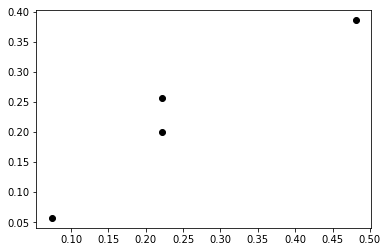

In [94]:
def plot_corr_edited_alleles(locus, timepoint, color):
    
    select_samples_by_locus = sample_dataframe['Locus'] == locus
    select_samples_by_target = sample_dataframe['Type'] == 'locus'
    select_samples_by_timepoint = sample_dataframe['Timepoint'] == timepoint
    
    select_samples = select_samples_by_locus & select_samples_by_target & select_samples_by_timepoint
    
    sample_pair = sorted(list(sample_dataframe[select_samples].index))
    
    allele_frac_1 = genotype_proportions(sample_pair[0])
    allele_frac_2 = genotype_proportions(sample_pair[1])
    
    allele_series_1 = pd.Series(allele_frac_1)
    allele_series_2 = pd.Series(allele_frac_2)

    combined_df = pd.DataFrame(dict((allele_series_1) = allele_series_1, allele_series_2 = allele_series_2))
    
    rename_dict = {'allele_series_1':str(locus+'_'+timepoint+'_1'),'allele_series_2':str(locus+'_'+timepoint+'_2')}
    
    combined_df.rename(columns=rename_dict, inplace=True)
    
    plt.plot(combined_df[str(locus+'_'+timepoint+'_1')], combined_df[str(locus+'_'+timepoint+'_2')], marker = 'o', color = color, linestyle='none')
    
    
    #print(scipy.stats.spearmanr(combined_df[str(locus+'_'+timepoint+'_1')], combined_df[str(locus+'_'+timepoint+'_2')], nan_policy='omit'))
    
    nb_comparisons = len(combined_df[~(combined_df.isnull().any(axis=1))])
    
    #print(nb_comparisons)

    
    return combined_df

plot_corr_edited_alleles('CDC11', 'T12', 'black')
    
    

In [95]:
def get_corr_coeff_co_edit_rates(locus, target, color):
    
    csv_path = './results/co_editing_rate/'+locus+'_'+target+'.csv'
    
    co_edit_rate_df = pd.read_csv(csv_path, index_col = 0)
    
    rep_1_vals = []
    rep_2_vals = []
    
    pos_genotypes = list(co_edit_rate_df.index)
    
    for genotype in pos_genotypes:
        
        for timepoint in ['T0', 'T6', 'T12', 'Plating', 'can_recov']:
            
            for rep in ['_1', '_2']:
                
                if rep == '_1':
                    
                    col_name = timepoint+rep
                    rep_1_vals.append(co_edit_rate_df.loc[genotype][col_name])
                    
                elif rep == '_2':
                    
                    col_name = timepoint+rep
                    rep_2_vals.append(co_edit_rate_df.loc[genotype][col_name])
        
    plt.plot(rep_1_vals,rep_2_vals, marker = 'o', color = color, linestyle='none')
    
    return rep_1_vals, rep_2_vals


In [96]:
%matplotlib inline


SpearmanrResult(correlation=0.9225955805492603, pvalue=5.263099785186655e-66)
SpearmanrResult(correlation=0.9307422559906487, pvalue=1.408087469069058e-26)
60
SpearmanrResult(correlation=0.966066345691969, pvalue=8.781261372632078e-128)
220
NA
['ADE1', 'POB3', 'CBK1', 'TRE2', 'TRL1', 'PSE1', 'ERO1', 'CDC11', 'MCM6', 'SES1', 'YCL074W', 'VPS17']
SpearmanrResult(correlation=0.8792218450421508, pvalue=3.4012268718016043e-101)
30
0.014533747382953516 0.013036389300410987 0.02912007636915532 0.0021322169008738774
Ttest_relResult(statistic=-1.1610274611986406, pvalue=0.2550987927841082)
Ttest_relResult(statistic=2.813346814406402, pvalue=0.00871119335736452)
Ttest_relResult(statistic=3.3018502104260397, pvalue=0.002554684112225383)
WilcoxonResult(statistic=162.0, pvalue=0.1470395786434527)
WilcoxonResult(statistic=58.0, pvalue=0.00033172583107637916)
WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


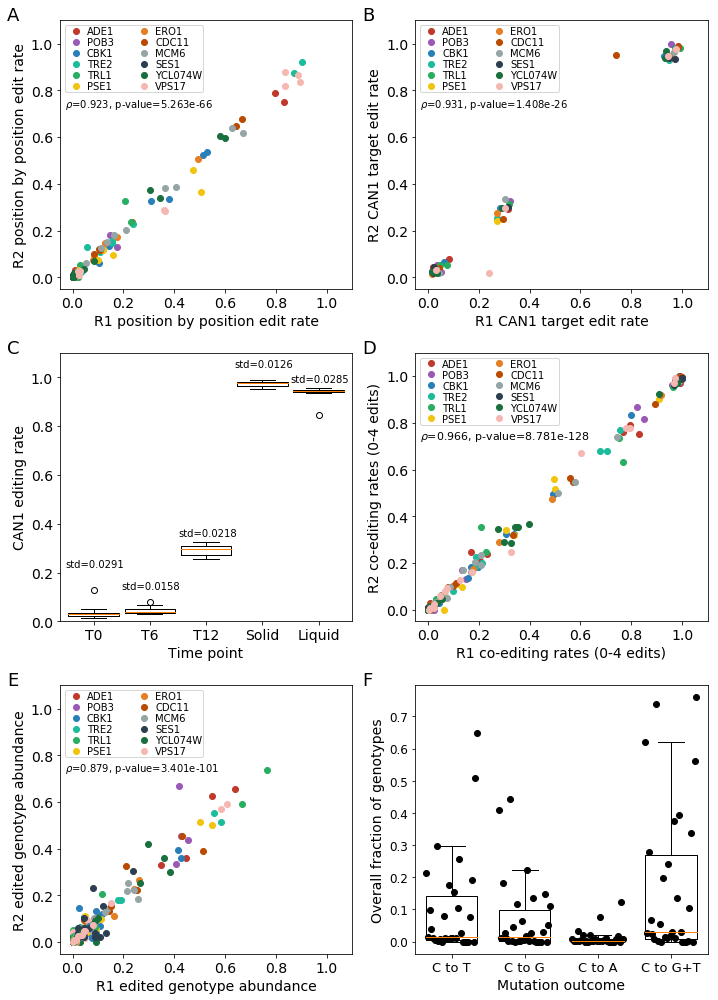

In [97]:
plt.figure(figsize = (10,14))

ax = plt.subplot(321)

######### For locus sequencing

colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']


alleles_plotted = []

all_rep_1 = []
all_rep_2 = []

for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
        
    pos_list = locus_edit_site_list_dict[locus]
    
    edit_rates = get_corr_coeff_total_edit_rates(locus, 'locus', pos_list, colors[x])
    
    all_rep_1 += edit_rates[0]
    all_rep_2 += edit_rates[1]
    
    alleles_plotted.append(locus)


plt.legend(alleles_plotted, loc='upper left', fontsize=10, ncol =2, borderpad =0.1, labelspacing = 0.1,
          handletextpad = 0.1)
plt.text(-0.03, 0.73, r'$\rho$=0.923, p-value=5.263e-66', fontsize = 10)

rep1_array = pd.Series(all_rep_1)
rep2_array = pd.Series(all_rep_2)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
    
print(scipy.stats.spearmanr(rep1_array, rep2_array, nan_policy='omit'))   

plt.ylabel('R2 position by position edit rate', fontsize = 14)
plt.xlabel('R1 position by position edit rate', fontsize = 14)




plt.xlim(-0.05,1.1)
plt.ylim(-0.05,1.1)
plt.text(-0.18, 1.0, 'A', transform = ax.transAxes, fontsize = 18)



ax = plt.subplot(322)

######### For CAN1 sequencing

colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']


alleles_plotted = []

all_rep_1 = []
all_rep_2 = []

for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
        
    pos_list = locus_edit_site_list_dict['CAN1']
    
    edit_rates = get_corr_coeff_total_edit_rates(locus, 'CAN1', pos_list, colors[x])
    
    all_rep_1 += edit_rates[0]
    all_rep_2 += edit_rates[1]
    
    alleles_plotted.append(locus)
    
plt.xlim(-0.05,1.1)
plt.ylim(-0.05,1.1)

plt.legend(alleles_plotted, loc='upper left', fontsize=10, ncol =2, borderpad =0.1, labelspacing = 0.1,
          handletextpad = 0.1)



rep1_array = pd.Series(all_rep_1)
rep2_array = pd.Series(all_rep_2)
    
print(scipy.stats.spearmanr(rep1_array, rep2_array, nan_policy='omit'))   



print(len(all_rep_1))


plt.text(-0.03, 0.73, r'$\rho$=0.931, p-value=1.408e-26', fontsize = 10)

plt.ylabel('R2 CAN1 target edit rate', fontsize=14)
plt.xlabel('R1 CAN1 target edit rate', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.text(-0.18, 1.0, 'B', transform = ax.transAxes, fontsize = 18)


#### boxplot of CAN1 timepoint by timepoint
ax  = plt.subplot(323)


all_rep_1 = []
all_rep_2 = []


for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
        
    pos_list = locus_edit_site_list_dict['CAN1']
    
    edit_rates = get_corr_coeff_total_edit_rates(locus, 'CAN1', pos_list, colors[x], plot=False)
    
    all_rep_1 += edit_rates[0]
    all_rep_2 += edit_rates[1]
    
    alleles_plotted.append(locus)


average_CAN1 = [(all_rep_1[x]+all_rep_2[x])/2 for x in range(0,len(all_rep_1))]

T0_indexes = [x for x in range(0,60, 5)]
T0_values = [average_CAN1[x] for x in T0_indexes]

T6_indexes = [x+1 for x in range(0,60, 5)]
T6_values = [average_CAN1[x] for x in T6_indexes]

T12_indexes = [x+2 for x in range(0,60, 5)]
T12_values = [average_CAN1[x] for x in T12_indexes]

solid_indexes = [x+3 for x in range(0,60, 5)]
solid_values = [average_CAN1[x] for x in solid_indexes]

liquid_indexes = [x+4 for x in range(0,60, 5)]
liquid_values = [average_CAN1[x] for x in liquid_indexes if x != 34]



plt.boxplot([T0_values, T6_values, T12_values, solid_values, liquid_values], widths = 0.9)

plt.text(0.5, 0.22, ('std='+str(round(np.std(T0_values), 4))))
plt.text(1.5, 0.13, ('std='+str(round(np.std(T6_values), 4))))
plt.text(2.5, 0.35, ('std='+str(round(np.std(T12_values), 4))))
plt.text(3.5, 1.04, ('std='+str(round(np.std(solid_values), 4))))
plt.text(4.5, 0.98, ('std='+str(round(np.std(liquid_values), 4))))






plt.ylabel('CAN1 editing rate', fontsize=14)
plt.xlabel('Time point', fontsize=14)
plt.xticks([1,2,3,4,5], ['T0', 'T6', 'T12', 'Solid', 'Liquid'])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.ylim(0,1.1)
plt.xlim(0.4,5.6)

plt.text(-0.18, 1.0, 'C', transform = ax.transAxes, fontsize = 18)


#### Co-edit rate correlation
ax = plt.subplot(324)


colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']


alleles_plotted = []

all_rep_1 = []
all_rep_2 = []

for x in range(0,12):
    
    locus = list(sample_dataframe.Locus.unique())[x]
           
    co_edit_rates = get_corr_coeff_co_edit_rates(locus, 'locus', colors[x])
    
    all_rep_1 += co_edit_rates[0]
    all_rep_2 += co_edit_rates[1]
    
    alleles_plotted.append(locus)
    
plt.xlim(-0.05,1.1)
plt.ylim(-0.05,1.1)

plt.legend(alleles_plotted, loc='upper left', fontsize=10, ncol =2, borderpad =0.1, labelspacing = 0.1,
          handletextpad = 0.1)
plt.text(-0.03, 0.73, r'$\rho$=0.966, p-value=8.781e-128', fontsize = 11)

rep1_array = pd.Series(all_rep_1)
rep2_array = pd.Series(all_rep_2)

plt.xticks(fontsize=12)
plt.yticks(fontsize =12)
    
print(scipy.stats.spearmanr(rep1_array, rep2_array, nan_policy='omit'))   


print(len(all_rep_1))



plt.ylabel('R2 co-editing rates (0-4 edits)', fontsize = 14)
plt.xlabel('R1 co-editing rates (0-4 edits)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.text(-0.18, 1.0, 'D', transform = ax.transAxes, fontsize = 18)




#### Allele fractions correlation
ax = plt.subplot(325)


colors = ['#C0392B', '#9B59B6', '#2980B9', '#1ABC9C', '#27AE60', '#F1C40F', '#E67E22', '#BA4A00', '#95A5A6', '#2C3E50', '#196F3D', '#F5B7B1']

rep1_list = []
rep2_list = []

alleles_plotted = []



for timepoint in ['Plating', 'can_recov']:

    for x in range(0,12):

        locus = list(sample_dataframe.Locus.unique())[x]

        if locus == 'ERO1' and timepoint == 'can_recov':
            print('NA')

        else:      
            temp_df = plot_corr_edited_alleles(locus, timepoint, color = colors[x])

            in_both_rep = temp_df[~(temp_df.isnull().any(axis=1))]

            for genotype in list(in_both_rep.index):

                frac_1 = in_both_rep.loc[genotype][str(locus+'_'+timepoint+'_1')]
                rep1_list.append(frac_1)

                frac_2 = in_both_rep.loc[genotype][str(locus+'_'+timepoint+'_2')]
                rep2_list.append(frac_2)

            if locus not in alleles_plotted:

                alleles_plotted.append(locus)

                
print(alleles_plotted)                


print(scipy.stats.spearmanr(rep1_list, rep2_list))

plt.legend(alleles_plotted, loc='upper left', fontsize=10, ncol =2, borderpad =0.1, labelspacing = 0.1,
          handletextpad = 0.1)
plt.text(-0.03, 0.73, r'$\rho$=0.879, p-value=3.401e-101', fontsize = 10)
          

plt.xlim(-0.05,1.1)
plt.ylim(-0.05,1.1)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.ylabel('R2 edited genotype abundance', fontsize = 14)
plt.xlabel('R1 edited genotype abundance', fontsize = 14)

plt.text(-0.18, 1.0, 'E', transform = ax.transAxes, fontsize = 18)


#### Normalized fraction of mutagenesis products
ax = plt.subplot(326)
n_pos = 0

to_G_list = []
to_T_list = []
to_A_list = []

n_site_list = []

for sample_ID in [9,19,29,39,49,59,67,79,89,99,109,119]:
    
    if sample_ID == 67:
        
        site_prop_dict = get_mut_prop_data_points_normalized(sample_ID, 'Plating')
        
    else:
        
        site_prop_dict = get_mut_prop_data_points_normalized(sample_ID, 'can_recov')
        
    to_G_list += site_prop_dict['toG'].values()
    to_T_list += site_prop_dict['toT'].values()
    to_A_list += site_prop_dict['toA'].values()
    
    n_pos += len(site_prop_dict['toG'].values())
    n_site_list.append(len(site_prop_dict['toG'].values()))
    
    
ToGorT = [(to_G_list[x]+to_T_list[x]) for x in range(0, len(to_G_list))]
    
plt.boxplot([to_T_list, to_G_list, to_A_list, ToGorT], positions = [1,2,3,4], widths = 0.7, showfliers=False)
print(n_pos)

data_point_x = list(np.arange(0.65, 1.35,0.024))




for x in data_point_x:
    
    plt.plot(x+1, to_G_list[data_point_x.index(x)], 'ko')
    plt.plot(x, to_T_list[data_point_x.index(x)], 'ko')
    plt.plot(x+3, ToGorT[data_point_x.index(x)], 'ko')
    plt.plot(x+2, to_A_list[data_point_x.index(x)], 'ko')
    
plt.ylabel('Overall fraction of genotypes', fontsize = 14)
plt.yticks(fontsize=12)

plt.xticks([1,2,3,4], ['C to T', 'C to G', 'C to A', 'C to G+T'], fontsize = 13)

plt.xlabel('Mutation outcome', fontsize = 14)

print(np.median(to_G_list), np.median(to_T_list), np.median(ToGorT), np.median(to_A_list))


print(scipy.stats.wilcoxon(to_G_list, to_T_list))
print(scipy.stats.wilcoxon(to_G_list, to_A_list))
print(scipy.stats.wilcoxon(to_T_list, to_A_list))

plt.text(-0.18, 1.0, 'F', transform = ax.transAxes, fontsize = 18)


plt.tight_layout()

plt.savefig('./figure_S4.svg', format='svg', dpi=600)
